## Importing libraries

In [669]:
import pandas as pd
pd.set_option("display.max_columns", 300)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, 
                                    cross_val_score, KFold, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, roc_curve, auc, 
                            roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

import itertools
import time

In [418]:
%%capture
from tqdm import tqdm
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

### Import cleaned dataset

In [4]:
cleaned_dataset = pd.read_csv('cleaned_dataset2008-2017.csv')
cleaned_dataset.head()

,aircraft_category,aircraft_damage,amateur_built,broad_phase_of_flight,engine_type,event_date,far_description,location,make,model,number_of_engines,purpose_of_flight,weather_condition,month,weekday,fatality,state,make_transformed,make_transformed_all,far_transformed
0,Airplane,Substantial,No,MANEUVERING,Reciprocating,2016-12-27,Part 91: General Aviation,"Bridgeport, AL",CESSNA,172,1.0,Personal,VMC,12,1,0,AL,cessna,cessna,Part_91_General_Aviation
1,Airplane,Substantial,No,TAXI,Reciprocating,2016-12-28,Part 91: General Aviation,"Prairie Du Sac, WI",CESSNA,172B,1.0,Personal,VMC,12,2,0,WI,cessna,cessna,Part_91_General_Aviation
2,Airplane,Substantial,No,APPROACH,Reciprocating,2016-12-16,Part 91: General Aviation,"Kewanee, IL",PIPER,PA28R,1.0,Personal,IMC,12,4,0,IL,piper,piper,Part_91_General_Aviation
3,Airplane,Substantial,No,TAKEOFF,Reciprocating,2016-12-16,Part 91: General Aviation,"Ionia, MI",STINSON,108-3,1.0,Personal,VMC,12,4,0,MI,stinson,stinson,Part_91_General_Aviation
4,Airplane,Minor,No,DESCENT,Reciprocating,2016-11-20,Part 135: Air Taxi & Commuter,"McGrath, AK",PIPER,PA 32R-300,1.0,Air_Carrier,VMC,11,6,0,AK,piper,piper,Part_135_Air_Taxi__Commuter


In [11]:
cleaned_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13111 entries, 0 to 13110
Data columns (total 20 columns):
aircraft_category        13111 non-null object
aircraft_damage          13111 non-null object
amateur_built            13111 non-null object
broad_phase_of_flight    13111 non-null object
engine_type              13111 non-null object
event_date               13111 non-null object
far_description          13111 non-null object
location                 13100 non-null object
make                     13110 non-null object
model                    13110 non-null object
number_of_engines        13111 non-null object
purpose_of_flight        13111 non-null object
weather_condition        13111 non-null object
month                    13111 non-null int64
weekday                  13111 non-null int64
fatality                 13111 non-null int64
state                    13111 non-null object
make_transformed         13111 non-null object
make_transformed_all     13111 non-null object
f

### Transform dataset for modeling

In [135]:
columns_for_model = ['aircraft_category', 'aircraft_damage', 'amateur_built', 'broad_phase_of_flight', 'engine_type', 'number_of_engines', 'purpose_of_flight', 'weather_condition', 'month', 'weekday', 'state', 'make_transformed', 'far_transformed']

In [7]:
data = cleaned_dataset[columns_for_model].copy()
data.head()

,aircraft_category,aircraft_damage,amateur_built,broad_phase_of_flight,engine_type,number_of_engines,purpose_of_flight,weather_condition,month,weekday,state,make_transformed,far_transformed
0,Airplane,Substantial,No,MANEUVERING,Reciprocating,1.0,Personal,VMC,12,1,AL,cessna,Part_91_General_Aviation
1,Airplane,Substantial,No,TAXI,Reciprocating,1.0,Personal,VMC,12,2,WI,cessna,Part_91_General_Aviation
2,Airplane,Substantial,No,APPROACH,Reciprocating,1.0,Personal,IMC,12,4,IL,piper,Part_91_General_Aviation
3,Airplane,Substantial,No,TAKEOFF,Reciprocating,1.0,Personal,VMC,12,4,MI,stinson,Part_91_General_Aviation
4,Airplane,Minor,No,DESCENT,Reciprocating,1.0,Air_Carrier,VMC,11,6,AK,piper,Part_135_Air_Taxi__Commuter


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13111 entries, 0 to 13110
Data columns (total 13 columns):
aircraft_category        13111 non-null object
aircraft_damage          13111 non-null object
amateur_built            13111 non-null object
broad_phase_of_flight    13111 non-null object
engine_type              13111 non-null object
number_of_engines        13111 non-null object
purpose_of_flight        13111 non-null object
weather_condition        13111 non-null object
month                    13111 non-null object
weekday                  13111 non-null object
state                    13111 non-null object
make_transformed         13111 non-null object
far_transformed          13111 non-null object
dtypes: object(13)
memory usage: 1.3+ MB


In [13]:
target_df = cleaned_dataset['fatality'].copy()
target_df.shape

(13111,)

In [9]:
data.month = data.month.apply(lambda x: str(x))
data.weekday = data.weekday.apply(lambda x: str(x))
data.number_of_engines = data.number_of_engines.apply(lambda x: str(x))

In [10]:
#One hot encode the training data and show the resulting dataframe with proper column names
ohe = OneHotEncoder()

ohe.fit(data)
data_ohe = ohe.transform(data).toarray()

#Creating this dataframe is not necessary its only to show the result of the ohe
ohe_df = pd.DataFrame(data_ohe, columns=ohe.get_feature_names(data.columns))

ohe_df.head()

,aircraft_category_Airplane,aircraft_category_Balloon,aircraft_category_Glider,aircraft_category_Gyrocraft,aircraft_category_Gyroplane,aircraft_category_Helicopter,aircraft_category_Powered_Parachute,aircraft_category_Rocket,aircraft_category_Ultralight,aircraft_category_Unknown,aircraft_category_Weight-Shift,aircraft_damage_Destroyed,aircraft_damage_Minor,aircraft_damage_NOT-SPECIFIED,aircraft_damage_Substantial,amateur_built_No,amateur_built_Yes,broad_phase_of_flight_APPROACH,broad_phase_of_flight_CLIMB,broad_phase_of_flight_CRUISE,broad_phase_of_flight_DESCENT,broad_phase_of_flight_GO-AROUND,broad_phase_of_flight_LANDING,broad_phase_of_flight_MANEUVERING,broad_phase_of_flight_NOT-SPECIFIED,broad_phase_of_flight_OTHER,broad_phase_of_flight_STANDING,broad_phase_of_flight_TAKEOFF,broad_phase_of_flight_TAXI,broad_phase_of_flight_UNKNOWN,engine_type_None,engine_type_Reciprocating,engine_type_Turbo_Fan,engine_type_Turbo_Jet,engine_type_Turbo_Prop,engine_type_Turbo_Shaft,engine_type_Unknown,engine_type_other,number_of_engines_0.0,number_of_engines_1.0,number_of_engines_2.0,number_of_engines_3.0,number_of_engines_4.0,number_of_engines_Unknown,purpose_of_flight_Aerial_Application,purpose_of_flight_Aerial_Observation,purpose_of_flight_Air_Carrier,purpose_of_flight_Air_Drop,purpose_of_flight_Air_Race_Show,purpose_of_flight_Banner_Tow,purpose_of_flight_Business,purpose_of_flight_Executive_Corporate,purpose_of_flight_External_Load,purpose_of_flight_Ferry,purpose_of_flight_Firefighting,purpose_of_flight_Flight_Test,purpose_of_flight_Glider_Tow,purpose_of_flight_Instructional,purpose_of_flight_Other_Work_Use,purpose_of_flight_Personal,purpose_of_flight_Positioning,purpose_of_flight_Public_Aircraft,purpose_of_flight_Public_Aircraft__Federal,purpose_of_flight_Public_Aircraft__Local,purpose_of_flight_Public_Aircraft__State,purpose_of_flight_Skydiving,purpose_of_flight_Unknown,weather_condition_IMC,weather_condition_UNK,weather_condition_Unknown,weather_condition_VMC,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,state_AK,state_AL,state_AO,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GM,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_ON,state_OR,state_PA,state_PO,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_unknown,make_transformed_aero,make_transformed_aeronca,make_transformed_air,make_transformed_airbus,make_transformed_american,make_transformed_aviat,make_transformed_ayres,make_transformed_beech,make_transformed_bell,make_transformed_bellanca,make_transformed_boeing,make_transformed_cessna,make_transformed_champion,make_transformed_cirrus,make_transformed_dehavilland,make_transformed_diamond,make_transformed_eurocopter,make_transformed_grumman,make_transformed_hughes,make_transformed_luscombe,make_transformed_maule,make_transformed_mcdonnell,make_transformed_mooney,make_transformed_north,make_transformed_other,make_transformed_piper,make_transformed_robinson,make_transformed_rockwell,make_transformed_schweizer,make_transformed_stinson,make_transformed_taylorcraft,make_transformed_unknown,far_transformed_Part_121_Air_Carrier,far_transformed_Part_129_Foreign,far_transformed_Part_133_Rotorcraft_Ext_Load,far_transformed_Part_135_Air_Taxi__Commuter,far_transformed_Part_137_Agricultural,far_transformed_Part_91_General_Aviation,far_transformed_Public_Aircraft,far_transformed_Public_Use,far_transformed_Unknown,far_transformed_other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

### Logistic regression

#### Running model with all parameters

In [14]:
num_of_trials = 30

In [34]:
clsf_van = LogisticRegression(random_state=2)

In [755]:
# creating empty arrays for results
nested_scores_f1 = np.zeros(num_of_trials)
nested_scores_rocauc = np.zeros(num_of_trials)
nested_scores_prec = np.zeros(num_of_trials)
nested_scores_rec = np.zeros(num_of_trials)
non_nested_scores = np.zeros(num_of_trials)

# setting scoring metrics
scoring = ['f1', 'roc_auc', 'precision', 'recall']

# specifying grid for search
p_grid = {"C": [1, 10, 100]}

for trial in tqdm(range(num_of_trials)):
    cv = KFold(n_splits=5, shuffle=True, random_state=trial)
    clf = GridSearchCV(estimator=clsf_van, param_grid=p_grid, cv=cv, scoring = 'f1',
               iid=False)
    clf.fit(ohe_df, target_df)
    non_nested_scores[trial] = clf.best_score_
    score = cross_validate(clsf_van, X=ohe_df, y=target_df, cv=cv, scoring = scoring)
    y_proba_log = np.array(cross_val_predict(clsf_van, ohe_df, target_df, cv=cv, method='predict_proba'))
    nested_scores_f1[trial] = score['test_f1'].mean()
    nested_scores_rocauc[trial] = score['test_roc_auc'].mean()
    nested_scores_prec[trial] = score['test_precision'].mean()
    nested_scores_rec[trial] = score['test_recall'].mean()



  0%|          | 0/1 [00:00<?, ?it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specif

Verifying results for logistic regression in nested and non-nested cross validation:

In [638]:
print("F1: %0.2f (+/- %0.2f)" % (nested_scores_f1.mean(), nested_scores_f1.std() * 2))
print("ROCAUC: %0.2f (+/- %0.2f)" % (nested_scores_rocauc.mean(), nested_scores_rocauc.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (non_nested_scores.mean(), non_nested_scores.std() * 2))

F1: 0.53 (+/- 0.00)
ROCAUC: 0.85 (+/- 0.00)
F1: 0.54 (+/- 0.00)


Verifying more metrics for nested cross validation:

In [758]:
print("F1: %0.4f (+/- %0.2f)" % (nested_scores_f1.mean(), nested_scores_f1.std() * 2))
print("ROCAUC: %0.2f (+/- %0.2f)" % (nested_scores_rocauc.mean(), nested_scores_rocauc.std() * 2))
# print("F1: %0.2f (+/- %0.2f)" % (non_nested_scores_up.mean(), non_nested_scores_up.std() * 2))
print("Recall: %0.4f (+/- %0.2f)" % (nested_scores_rec.mean(), nested_scores_rec.std() * 2))
print("Precision: %0.4f (+/- %0.2f)" % (nested_scores_prec.mean(), nested_scores_prec.std() * 2))

F1: 0.5308 (+/- 0.00)
ROCAUC: 0.85 (+/- 0.00)
Recall: 0.4132 (+/- 0.00)
Precision: 0.7436 (+/- 0.00)


In [759]:
num_of_trials = 10
log_f1 = np.zeros(num_of_trials)
log_rocauc = np.zeros(num_of_trials)
log_prec = np.zeros(num_of_trials)
log_rec = np.zeros(num_of_trials)

p_grid = {"C": [1, 10, 100]}

for trial in tqdm(range(num_of_trials)):
    data_train, data_test, target_train, target_test = train_test_split(ohe_df, target_df, test_size = 0.2)
    clsf_van.fit(data_train, target_train)
    y_pred_log = clsf_van.predict(data_test)
    print(classification_report(target_test, y_pred_log))
y_pred_log


  0%|          | 0/10 [00:00<?, ?it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 10%|█         | 1/10 [00:00<00:02,  4.09it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 20%|██        | 2/10 [00:00<00:01,  4.80it/s]

              precision    recall  f1-score   support

           0       0.88      0.97      0.93      2168
           1       0.75      0.39      0.51       455

    accuracy                           0.87      2623
   macro avg       0.82      0.68      0.72      2623
weighted avg       0.86      0.87      0.85      2623

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2156
           1       0.79      0.43      0.56       467

    accuracy                           0.88      2623
   macro avg       0.84      0.70      0.74      2623
weighted avg       0.87      0.88      0.86      2623



//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 30%|███       | 3/10 [00:00<00:01,  5.46it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 40%|████      | 4/10 [00:00<00:00,  6.05it/s]

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2146
           1       0.77      0.39      0.52       477

    accuracy                           0.87      2623
   macro avg       0.83      0.68      0.72      2623
weighted avg       0.86      0.87      0.85      2623

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2112
           1       0.76      0.39      0.52       511

    accuracy                           0.86      2623
   macro avg       0.82      0.68      0.72      2623
weighted avg       0.85      0.86      0.84      2623



//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 50%|█████     | 5/10 [00:00<00:00,  6.75it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 60%|██████    | 6/10 [00:00<00:00,  7.01it/s]

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2153
           1       0.76      0.43      0.55       470

    accuracy                           0.87      2623
   macro avg       0.83      0.70      0.74      2623
weighted avg       0.87      0.87      0.86      2623

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2172
           1       0.71      0.42      0.53       451

    accuracy                           0.87      2623
   macro avg       0.80      0.69      0.73      2623
weighted avg       0.86      0.87      0.86      2623



//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 70%|███████   | 7/10 [00:00<00:00,  7.44it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 80%|████████  | 8/10 [00:01<00:00,  7.67it/s]

              precision    recall  f1-score   support

           0       0.88      0.97      0.93      2159
           1       0.76      0.39      0.52       464

    accuracy                           0.87      2623
   macro avg       0.82      0.68      0.72      2623
weighted avg       0.86      0.87      0.85      2623

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2161
           1       0.71      0.38      0.49       462

    accuracy                           0.86      2623
   macro avg       0.80      0.67      0.71      2623
weighted avg       0.85      0.86      0.85      2623



//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

 90%|█████████ | 9/10 [00:01<00:00,  7.54it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

100%|██████████| 10/10 [00:01<00:00,  7.47it/s]

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2176
           1       0.71      0.41      0.52       447

    accuracy                           0.87      2623
   macro avg       0.80      0.69      0.73      2623
weighted avg       0.86      0.87      0.86      2623

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2132
           1       0.74      0.41      0.53       491

    accuracy                           0.86      2623
   macro avg       0.81      0.69      0.72      2623
weighted avg       0.85      0.86      0.85      2623



array([1, 0, 0, ..., 1, 0, 0])

Confusion matrix for first model

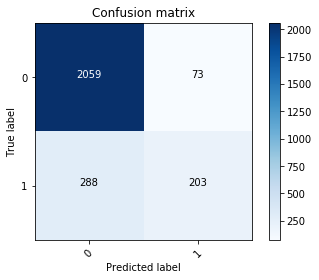

In [760]:
plot_confusion_matrix(confusion_matrix(target_test, y_pred_log), set(target_test))

Verification of ROC-AUC curve

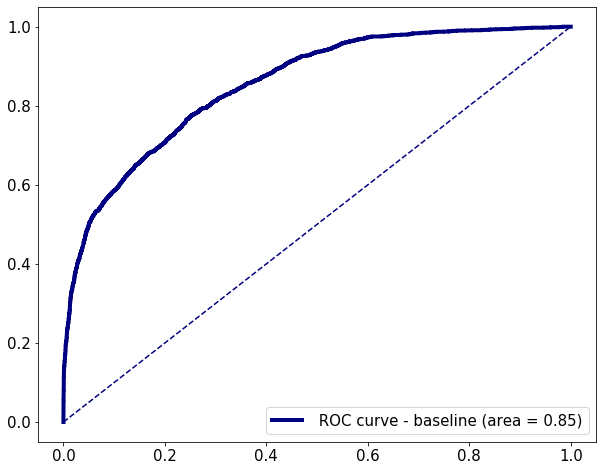

In [780]:
fpr_log, tpr_log, _ = roc_curve(target_df.ravel(), y_proba_log[:,1].ravel())
roc_auc_log = auc(fpr_log, tpr_log)

plt.figure(figsize = (10,8))
plot1 = plt.plot(fpr_log, tpr_log,
         label=' ROC curve - baseline (area = {0:0.2f})'
               ''.format(roc_auc_log),
         color='navy', linestyle='-', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xticks(rotation=0, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)

#### Verification of classification with only one feature - damage severity

In [38]:
num_of_trials = 30

In [39]:
clsf_damage = LogisticRegression(random_state=2)

In [40]:
data_damage = pd.DataFrame(cleaned_dataset['aircraft_damage'].copy())

In [42]:
#One hot encode the training data and show the resulting dataframe with proper column names
ohe_d = OneHotEncoder()

ohe_d.fit(data_damage)
data_damage_ohe = ohe_d.transform(data_damage).toarray()

ohe_damage_df = pd.DataFrame(data_damage_ohe, columns=ohe_d.get_feature_names(data_damage.columns))

ohe_damage_df.head()

,aircraft_damage_Destroyed,aircraft_damage_Minor,aircraft_damage_NOT-SPECIFIED,aircraft_damage_Substantial
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0


In [282]:
nested_scores_damage_f1 = np.zeros(num_of_trials)
nested_scores_damage_rocauc = np.zeros(num_of_trials)
non_nested_scores_damage = np.zeros(num_of_trials)

p_grid = {"C": [1, 10, 100]}

for trial in tqdm(range(num_of_trials)):
    cv = KFold(n_splits=5, shuffle=True, random_state=trial)
    clf = GridSearchCV(estimator=clsf_damage, param_grid=p_grid, cv=cv, scoring = 'f1',
               iid=False)
    clf.fit(ohe_damage_df, target_df)
    non_nested_scores_damage[trial] = clf.best_score_
    score = cross_validate(clsf_damage, X=ohe_damage_df, y=target_df, cv=cv, scoring = scoring)
    y_proba_damage = np.array(cross_val_predict(clsf_damage, ohe_damage_df, target_df, cv=cv, method='predict_proba'))
    nested_scores_damage_f1[trial] = score['test_f1'].mean()
    nested_scores_damage_rocauc[trial] = score['test_roc_auc'].mean()

  0%|          | 0/1 [00:00<?, ?it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify

Verification of accuracy metrics for model with damage severity feature only

In [283]:
print("F1: %0.2f (+/- %0.2f)" % (nested_scores_damage_f1.mean(), nested_scores_damage_f1.std() * 2))
print("ROCAUC: %0.2f (+/- %0.2f)" % (nested_scores_damage_rocauc.mean(), nested_scores_damage_rocauc.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (non_nested_scores_damage.mean(), non_nested_scores_damage.std() * 2))

F1: 0.45 (+/- 0.00)
ROCAUC: 0.65 (+/- 0.00)
F1: 0.45 (+/- 0.00)


Verification of ROC-AUC curve

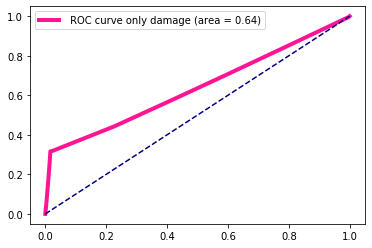

In [636]:
fpr_damage, tpr_damage, _ = roc_curve(target_df.ravel(), y_proba_damage[:,1].ravel())
roc_auc_damage = auc(fpr_damage, tpr_damage)

# Plot all ROC curves
plt.figure()
plt.plot(fpr_damage, tpr_damage,
         label=' ROC curve only damage (area = {0:0.2f})'
               ''.format(roc_auc_damage),
         color='deeppink', linestyle='-', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()

We can see that this model is performing much worse than model with all features

#### Verification of modeling without damage severity feature

In [44]:
num_of_trials = 30

In [47]:
columns_for_model_no_damage = ['aircraft_category', 'amateur_built', 'broad_phase_of_flight', 'engine_type', 'number_of_engines', 'purpose_of_flight', 'weather_condition', 'month', 'weekday', 'state', 'make_transformed', 'far_transformed']

In [48]:
data_no_damage = pd.DataFrame(cleaned_dataset[columns_for_model_no_damage].copy())
data_no_damage.head()

,aircraft_category,amateur_built,broad_phase_of_flight,engine_type,number_of_engines,purpose_of_flight,weather_condition,month,weekday,state,make_transformed,far_transformed
0,Airplane,No,MANEUVERING,Reciprocating,1.0,Personal,VMC,12,1,AL,cessna,Part_91_General_Aviation
1,Airplane,No,TAXI,Reciprocating,1.0,Personal,VMC,12,2,WI,cessna,Part_91_General_Aviation
2,Airplane,No,APPROACH,Reciprocating,1.0,Personal,IMC,12,4,IL,piper,Part_91_General_Aviation
3,Airplane,No,TAKEOFF,Reciprocating,1.0,Personal,VMC,12,4,MI,stinson,Part_91_General_Aviation
4,Airplane,No,DESCENT,Reciprocating,1.0,Air_Carrier,VMC,11,6,AK,piper,Part_135_Air_Taxi__Commuter


In [51]:
#One hot encode the training data and show the resulting dataframe with proper column names
ohe_nd = OneHotEncoder()

ohe_nd.fit(data_no_damage)
data_no_damage_ohe = ohe_nd.transform(data_no_damage).toarray()

ohe_no_damage_df = pd.DataFrame(data_no_damage_ohe, columns=ohe_nd.get_feature_names(data_no_damage.columns))

ohe_no_damage_df.head()

,aircraft_category_Airplane,aircraft_category_Balloon,aircraft_category_Glider,aircraft_category_Gyrocraft,aircraft_category_Gyroplane,aircraft_category_Helicopter,aircraft_category_Powered_Parachute,aircraft_category_Rocket,aircraft_category_Ultralight,aircraft_category_Unknown,aircraft_category_Weight-Shift,amateur_built_No,amateur_built_Yes,broad_phase_of_flight_APPROACH,broad_phase_of_flight_CLIMB,broad_phase_of_flight_CRUISE,broad_phase_of_flight_DESCENT,broad_phase_of_flight_GO-AROUND,broad_phase_of_flight_LANDING,broad_phase_of_flight_MANEUVERING,broad_phase_of_flight_NOT-SPECIFIED,broad_phase_of_flight_OTHER,broad_phase_of_flight_STANDING,broad_phase_of_flight_TAKEOFF,broad_phase_of_flight_TAXI,broad_phase_of_flight_UNKNOWN,engine_type_None,engine_type_Reciprocating,engine_type_Turbo_Fan,engine_type_Turbo_Jet,engine_type_Turbo_Prop,engine_type_Turbo_Shaft,engine_type_Unknown,engine_type_other,number_of_engines_0.0,number_of_engines_1.0,number_of_engines_2.0,number_of_engines_3.0,number_of_engines_4.0,number_of_engines_Unknown,purpose_of_flight_Aerial_Application,purpose_of_flight_Aerial_Observation,purpose_of_flight_Air_Carrier,purpose_of_flight_Air_Drop,purpose_of_flight_Air_Race_Show,purpose_of_flight_Banner_Tow,purpose_of_flight_Business,purpose_of_flight_Executive_Corporate,purpose_of_flight_External_Load,purpose_of_flight_Ferry,purpose_of_flight_Firefighting,purpose_of_flight_Flight_Test,purpose_of_flight_Glider_Tow,purpose_of_flight_Instructional,purpose_of_flight_Other_Work_Use,purpose_of_flight_Personal,purpose_of_flight_Positioning,purpose_of_flight_Public_Aircraft,purpose_of_flight_Public_Aircraft__Federal,purpose_of_flight_Public_Aircraft__Local,purpose_of_flight_Public_Aircraft__State,purpose_of_flight_Skydiving,purpose_of_flight_Unknown,weather_condition_IMC,weather_condition_UNK,weather_condition_Unknown,weather_condition_VMC,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,state_AK,state_AL,state_AO,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GM,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_ON,state_OR,state_PA,state_PO,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_unknown,make_transformed_aero,make_transformed_aeronca,make_transformed_air,make_transformed_airbus,make_transformed_american,make_transformed_aviat,make_transformed_ayres,make_transformed_beech,make_transformed_bell,make_transformed_bellanca,make_transformed_boeing,make_transformed_cessna,make_transformed_champion,make_transformed_cirrus,make_transformed_dehavilland,make_transformed_diamond,make_transformed_eurocopter,make_transformed_grumman,make_transformed_hughes,make_transformed_luscombe,make_transformed_maule,make_transformed_mcdonnell,make_transformed_mooney,make_transformed_north,make_transformed_other,make_transformed_piper,make_transformed_robinson,make_transformed_rockwell,make_transformed_schweizer,make_transformed_stinson,make_transformed_taylorcraft,make_transformed_unknown,far_transformed_Part_121_Air_Carrier,far_transformed_Part_129_Foreign,far_transformed_Part_133_Rotorcraft_Ext_Load,far_transformed_Part_135_Air_Taxi__Commuter,far_transformed_Part_137_Agricultural,far_transformed_Part_91_General_Aviation,far_transformed_Public_Aircraft,far_transformed_Public_Use,far_transformed_Unknown,far_transformed_other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.

In [45]:
clsf_no_damage = LogisticRegression(random_state=2)

In [641]:
nested_scores_no_damage_f1 = np.zeros(num_of_trials)
nested_scores_no_damage_rocauc = np.zeros(num_of_trials)
nested_scores_no_damage_prec = np.zeros(num_of_trials)
nested_scores_no_damage_rec = np.zeros(num_of_trials)
non_nested_scores_no_damage = np.zeros(num_of_trials)

scoring = ['f1', 'roc_auc', 'precision', 'recall']

p_grid = {"C": [1, 10, 100]}

for trial in tqdm(range(num_of_trials)):
    cv = KFold(n_splits=5, shuffle=True, random_state=trial)
    clf = GridSearchCV(estimator=clsf_no_damage, param_grid=p_grid, cv=cv, scoring = 'f1',
                   iid=False)
    clf.fit(ohe_no_damage_df, target_df)
    non_nested_scores_no_damage[trial] = clf.best_score_
    score = cross_validate(clsf_no_damage, X=ohe_no_damage_df, y=target_df, cv=cv, scoring = scoring)
    y_proba_no_damage = np.array(cross_val_predict(clsf_no_damage, ohe_no_damage_df, target_df, cv=cv, method='predict_proba'))
    nested_scores_no_damage_f1[trial] = score['test_f1'].mean()
    nested_scores_no_damage_rocauc[trial] = score['test_roc_auc'].mean()
    nested_scores_no_damage_prec[trial] = score['test_precision'].mean()
    nested_scores_no_damage_rec[trial] = score['test_recall'].mean()


  0%|          | 0/1 [00:00<?, ?it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specif

Verification of accuracy metrics

In [642]:
print("F1: %0.2f (+/- %0.2f)" % (nested_scores_no_damage_f1.mean(), nested_scores_no_damage_f1.std() * 2))
print("ROCAUC: %0.2f (+/- %0.2f)" % (nested_scores_no_damage_rocauc.mean(), nested_scores_no_damage_rocauc.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (nested_scores_no_damage_prec.mean(), nested_scores_no_damage_prec.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (nested_scores_no_damage_rec.mean(), nested_scores_no_damage_rec.std() * 2))

print("\nGridSearch F1: %0.2f (+/- %0.2f)" % (non_nested_scores_no_damage.mean(), non_nested_scores_no_damage.std() * 2))

F1: 0.37 (+/- 0.00)
ROCAUC: 0.81 (+/- 0.00)
Precision: 0.64 (+/- 0.00)
Recall: 0.26 (+/- 0.00)

GridSearch F1: 0.38 (+/- 0.00)


Verification of ROC-AUC curve

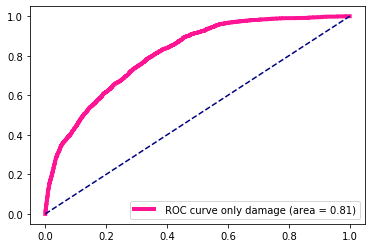

In [643]:
fpr_log_nd, tpr_log_nd, _ = roc_curve(target_df.ravel(), y_proba_no_damage[:,1].ravel())
roc_auc_log_nd = auc(fpr_log_nd, tpr_log_nd)

# Plot all ROC curves
plt.figure()
plt.plot(fpr_log_nd, tpr_log_nd,
         label=' ROC curve only damage (area = {0:0.2f})'
               ''.format(roc_auc_log_nd),
         color='deeppink', linestyle='-', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()

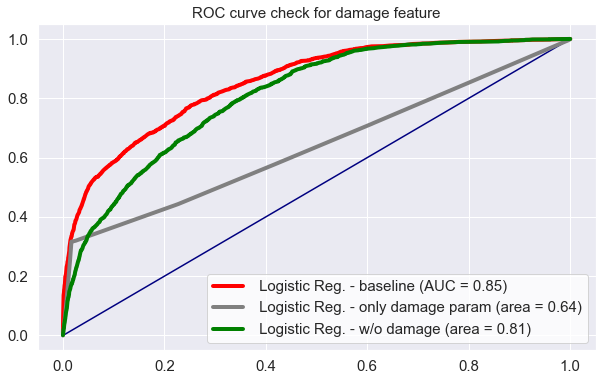

In [923]:
fig = plt.figure(figsize=(10,6))
sns.set()
sns.lineplot([0, 1], [0, 1], color='navy', linestyle='--')
sns.lineplot(fpr_log, tpr_log,
         label=' Logistic Reg. - baseline (AUC = {0:0.2f})'
               ''.format(roc_auc_log),
         color='red', linestyle=':', linewidth=4)
sns.lineplot(fpr_damage, tpr_damage,
         label=' Logistic Reg. - only damage param (area = {0:0.2f})'
               ''.format(roc_auc_damage),
         color='grey', linestyle=':', linewidth=4)

sns.lineplot(fpr_log_nd, tpr_log_nd,
         label=' Logistic Reg. - w/o damage (area = {0:0.2f})'
               ''.format(roc_auc_log_nd),
         color='green', linestyle=':', linewidth=4)
ax = plt.gca()
plt.title('ROC curve check for damage feature', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 15, facecolor= 'white')
fig.savefig('temp20.png',transparent = True, edgecolor='none')

We can see that results are better with damage severity feture included, but this feature is not the main predictor so we can continue using it in later models

### To improve accuracy of model predictions we have to handle high class imbalance. Three different approaches to this problem would be checked - upsampling, downsampling and SMOTE

### Upsampling

#### Running model using all features

In [126]:
scoring = ['f1', 'roc_auc', 'precision', 'recall']

In [111]:
for_upsampling = cleaned_dataset.copy()
for_upsampling.head()

,aircraft_category,aircraft_damage,amateur_built,broad_phase_of_flight,engine_type,event_date,far_description,location,make,model,number_of_engines,purpose_of_flight,weather_condition,month,weekday,fatality,state,make_transformed,make_transformed_all,far_transformed
0,Airplane,Substantial,No,MANEUVERING,Reciprocating,2016-12-27,Part 91: General Aviation,"Bridgeport, AL",CESSNA,172,1.0,Personal,VMC,12,1,0,AL,cessna,cessna,Part_91_General_Aviation
1,Airplane,Substantial,No,TAXI,Reciprocating,2016-12-28,Part 91: General Aviation,"Prairie Du Sac, WI",CESSNA,172B,1.0,Personal,VMC,12,2,0,WI,cessna,cessna,Part_91_General_Aviation
2,Airplane,Substantial,No,APPROACH,Reciprocating,2016-12-16,Part 91: General Aviation,"Kewanee, IL",PIPER,PA28R,1.0,Personal,IMC,12,4,0,IL,piper,piper,Part_91_General_Aviation
3,Airplane,Substantial,No,TAKEOFF,Reciprocating,2016-12-16,Part 91: General Aviation,"Ionia, MI",STINSON,108-3,1.0,Personal,VMC,12,4,0,MI,stinson,stinson,Part_91_General_Aviation
4,Airplane,Minor,No,DESCENT,Reciprocating,2016-11-20,Part 135: Air Taxi & Commuter,"McGrath, AK",PIPER,PA 32R-300,1.0,Air_Carrier,VMC,11,6,0,AK,piper,piper,Part_135_Air_Taxi__Commuter


In [114]:
for_upsampling['fatality'].value_counts()

0    10772
1     2339
Name: fatality, dtype: int64

In [116]:
# Separate majority and minority classes
df_majority = for_upsampling[for_upsampling['fatality']==0]
df_minority = for_upsampling[for_upsampling['fatality']==1]

In [118]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=10772,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.fatality.value_counts()

1    10772
0    10772
Name: fatality, dtype: int64

In [119]:
num_of_trials = 30

In [138]:
columns_for_model

['aircraft_category',
 'aircraft_damage',
 'amateur_built',
 'broad_phase_of_flight',
 'engine_type',
 'number_of_engines',
 'purpose_of_flight',
 'weather_condition',
 'month',
 'weekday',
 'state',
 'make_transformed',
 'far_transformed']

In [139]:
data_upsampled = df_upsampled[columns_for_model]
target_upsampled = df_upsampled['fatality']

In [345]:
data_upsampled.shape

(21544, 13)

In [346]:
target_upsampled.shape

(21544,)

In [140]:
#One hot encode the training data and show the resulting dataframe with proper column names
ohe = OneHotEncoder()

ohe.fit(data_upsampled)
data_ohe_up = ohe.transform(data_upsampled).toarray()

ohe_upsampled_df = pd.DataFrame(data_ohe_up, columns=ohe.get_feature_names(data_upsampled.columns))

ohe_upsampled_df.head()

,aircraft_category_Airplane,aircraft_category_Balloon,aircraft_category_Glider,aircraft_category_Gyrocraft,aircraft_category_Gyroplane,aircraft_category_Helicopter,aircraft_category_Powered_Parachute,aircraft_category_Rocket,aircraft_category_Ultralight,aircraft_category_Unknown,aircraft_category_Weight-Shift,aircraft_damage_Destroyed,aircraft_damage_Minor,aircraft_damage_NOT-SPECIFIED,aircraft_damage_Substantial,amateur_built_No,amateur_built_Yes,broad_phase_of_flight_APPROACH,broad_phase_of_flight_CLIMB,broad_phase_of_flight_CRUISE,broad_phase_of_flight_DESCENT,broad_phase_of_flight_GO-AROUND,broad_phase_of_flight_LANDING,broad_phase_of_flight_MANEUVERING,broad_phase_of_flight_NOT-SPECIFIED,broad_phase_of_flight_OTHER,broad_phase_of_flight_STANDING,broad_phase_of_flight_TAKEOFF,broad_phase_of_flight_TAXI,broad_phase_of_flight_UNKNOWN,engine_type_None,engine_type_Reciprocating,engine_type_Turbo_Fan,engine_type_Turbo_Jet,engine_type_Turbo_Prop,engine_type_Turbo_Shaft,engine_type_Unknown,engine_type_other,number_of_engines_0.0,number_of_engines_1.0,number_of_engines_2.0,number_of_engines_3.0,number_of_engines_4.0,number_of_engines_Unknown,purpose_of_flight_Aerial_Application,purpose_of_flight_Aerial_Observation,purpose_of_flight_Air_Carrier,purpose_of_flight_Air_Drop,purpose_of_flight_Air_Race_Show,purpose_of_flight_Banner_Tow,purpose_of_flight_Business,purpose_of_flight_Executive_Corporate,purpose_of_flight_External_Load,purpose_of_flight_Ferry,purpose_of_flight_Firefighting,purpose_of_flight_Flight_Test,purpose_of_flight_Glider_Tow,purpose_of_flight_Instructional,purpose_of_flight_Other_Work_Use,purpose_of_flight_Personal,purpose_of_flight_Positioning,purpose_of_flight_Public_Aircraft,purpose_of_flight_Public_Aircraft__Federal,purpose_of_flight_Public_Aircraft__Local,purpose_of_flight_Public_Aircraft__State,purpose_of_flight_Skydiving,purpose_of_flight_Unknown,weather_condition_IMC,weather_condition_UNK,weather_condition_Unknown,weather_condition_VMC,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,state_AK,state_AL,state_AO,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GM,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_ON,state_OR,state_PA,state_PO,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_unknown,make_transformed_aero,make_transformed_aeronca,make_transformed_air,make_transformed_airbus,make_transformed_american,make_transformed_aviat,make_transformed_ayres,make_transformed_beech,make_transformed_bell,make_transformed_bellanca,make_transformed_boeing,make_transformed_cessna,make_transformed_champion,make_transformed_cirrus,make_transformed_dehavilland,make_transformed_diamond,make_transformed_eurocopter,make_transformed_grumman,make_transformed_hughes,make_transformed_luscombe,make_transformed_maule,make_transformed_mcdonnell,make_transformed_mooney,make_transformed_north,make_transformed_other,make_transformed_piper,make_transformed_robinson,make_transformed_rockwell,make_transformed_schweizer,make_transformed_stinson,make_transformed_taylorcraft,make_transformed_unknown,far_transformed_Part_121_Air_Carrier,far_transformed_Part_129_Foreign,far_transformed_Part_133_Rotorcraft_Ext_Load,far_transformed_Part_135_Air_Taxi__Commuter,far_transformed_Part_137_Agricultural,far_transformed_Part_91_General_Aviation,far_transformed_Public_Aircraft,far_transformed_Public_Use,far_transformed_Unknown,far_transformed_other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [344]:
ohe_upsampled_df.shape

(21544, 192)

In [162]:
clsf_van_up = LogisticRegression()

In [233]:
num_of_trials = 1
nested_scores_up_f1 = np.zeros(num_of_trials)
nested_scores_up_rocauc = np.zeros(num_of_trials)
nested_scores_up_prec = np.zeros(num_of_trials)
nested_scores_up_rec = np.zeros(num_of_trials)

p_grid = {"C": [1, 10, 100]}

for trial in tqdm(range(num_of_trials)):
    cv = KFold(n_splits=5, shuffle=True, random_state=trial)
    score = cross_validate(clsf_van_up, X=ohe_upsampled_df, y=target_upsampled, cv=cv, scoring = scoring)
    y_pred_up = cross_val_predict(clsf_van_up, ohe_upsampled_df, target_upsampled, cv=cv)
    y_proba_up = np.array(cross_val_predict(clsf_van_up, ohe_upsampled_df, target_upsampled, cv=cv, method='predict_proba'))
    nested_scores_up_f1[trial] = score['test_f1'].mean()
    nested_scores_up_rocauc[trial] = score['test_roc_auc'].mean()
    nested_scores_up_prec[trial] = score['test_precision'].mean()
    nested_scores_up_rec[trial] = score['test_recall'].mean()

  0%|          | 0/1 [00:00<?, ?it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify

Verification of accuracy metrics

In [234]:
print("F1: %0.4f (+/- %0.2f)" % (nested_scores_up_f1.mean(), nested_scores_up_f1.std() * 2))
print("ROCAUC: %0.2f (+/- %0.2f)" % (nested_scores_up_rocauc.mean(), nested_scores_up_rocauc.std() * 2))
print("Recall: %0.4f (+/- %0.2f)" % (nested_scores_up_rec.mean(), nested_scores_up_rec.std() * 2))
print("Precision: %0.4f (+/- %0.2f)" % (nested_scores_up_prec.mean(), nested_scores_up_prec.std() * 2))

F1: 0.7769 (+/- 0.00)
ROCAUC: 0.87 (+/- 0.00)
Recall: 0.7755 (+/- 0.00)
Precision: 0.7783 (+/- 0.00)


We can see that accuracy of the model increased after upsampling

In [235]:
print(classification_report(target_upsampled, y_pred_up))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     10772
           1       0.78      0.78      0.78     10772

    accuracy                           0.78     21544
   macro avg       0.78      0.78      0.78     21544
weighted avg       0.78      0.78      0.78     21544



#### Running upsampled models without damage severity feature

In [136]:
data_upsampled_no_damage = df_upsampled[columns_for_model_no_damage]

In [137]:
#One hot encode the training data and show the resulting dataframe with proper column names
ohe_nd = OneHotEncoder()

ohe_nd.fit(data_upsampled_no_damage)
data_ohe_up_nd = ohe_nd.transform(data_upsampled_no_damage).toarray()

ohe_upsampled_no_damage_df = pd.DataFrame(data_ohe_up_nd, columns=ohe_nd.get_feature_names(data_upsampled_no_damage.columns))

ohe_upsampled_no_damage_df.head()

,aircraft_category_Airplane,aircraft_category_Balloon,aircraft_category_Glider,aircraft_category_Gyrocraft,aircraft_category_Gyroplane,aircraft_category_Helicopter,aircraft_category_Powered_Parachute,aircraft_category_Rocket,aircraft_category_Ultralight,aircraft_category_Unknown,aircraft_category_Weight-Shift,amateur_built_No,amateur_built_Yes,broad_phase_of_flight_APPROACH,broad_phase_of_flight_CLIMB,broad_phase_of_flight_CRUISE,broad_phase_of_flight_DESCENT,broad_phase_of_flight_GO-AROUND,broad_phase_of_flight_LANDING,broad_phase_of_flight_MANEUVERING,broad_phase_of_flight_NOT-SPECIFIED,broad_phase_of_flight_OTHER,broad_phase_of_flight_STANDING,broad_phase_of_flight_TAKEOFF,broad_phase_of_flight_TAXI,broad_phase_of_flight_UNKNOWN,engine_type_None,engine_type_Reciprocating,engine_type_Turbo_Fan,engine_type_Turbo_Jet,engine_type_Turbo_Prop,engine_type_Turbo_Shaft,engine_type_Unknown,engine_type_other,number_of_engines_0.0,number_of_engines_1.0,number_of_engines_2.0,number_of_engines_3.0,number_of_engines_4.0,number_of_engines_Unknown,purpose_of_flight_Aerial_Application,purpose_of_flight_Aerial_Observation,purpose_of_flight_Air_Carrier,purpose_of_flight_Air_Drop,purpose_of_flight_Air_Race_Show,purpose_of_flight_Banner_Tow,purpose_of_flight_Business,purpose_of_flight_Executive_Corporate,purpose_of_flight_External_Load,purpose_of_flight_Ferry,purpose_of_flight_Firefighting,purpose_of_flight_Flight_Test,purpose_of_flight_Glider_Tow,purpose_of_flight_Instructional,purpose_of_flight_Other_Work_Use,purpose_of_flight_Personal,purpose_of_flight_Positioning,purpose_of_flight_Public_Aircraft,purpose_of_flight_Public_Aircraft__Federal,purpose_of_flight_Public_Aircraft__Local,purpose_of_flight_Public_Aircraft__State,purpose_of_flight_Skydiving,purpose_of_flight_Unknown,weather_condition_IMC,weather_condition_UNK,weather_condition_Unknown,weather_condition_VMC,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,state_AK,state_AL,state_AO,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GM,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_ON,state_OR,state_PA,state_PO,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_unknown,make_transformed_aero,make_transformed_aeronca,make_transformed_air,make_transformed_airbus,make_transformed_american,make_transformed_aviat,make_transformed_ayres,make_transformed_beech,make_transformed_bell,make_transformed_bellanca,make_transformed_boeing,make_transformed_cessna,make_transformed_champion,make_transformed_cirrus,make_transformed_dehavilland,make_transformed_diamond,make_transformed_eurocopter,make_transformed_grumman,make_transformed_hughes,make_transformed_luscombe,make_transformed_maule,make_transformed_mcdonnell,make_transformed_mooney,make_transformed_north,make_transformed_other,make_transformed_piper,make_transformed_robinson,make_transformed_rockwell,make_transformed_schweizer,make_transformed_stinson,make_transformed_taylorcraft,make_transformed_unknown,far_transformed_Part_121_Air_Carrier,far_transformed_Part_129_Foreign,far_transformed_Part_133_Rotorcraft_Ext_Load,far_transformed_Part_135_Air_Taxi__Commuter,far_transformed_Part_137_Agricultural,far_transformed_Part_91_General_Aviation,far_transformed_Public_Aircraft,far_transformed_Public_Use,far_transformed_Unknown,far_transformed_other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.

In [131]:
clsf_van_up_nd = LogisticRegression(random_state=2)

In [205]:
num_of_trials = 1
nested_scores_up_nd_f1 = np.zeros(num_of_trials)
nested_scores_up_nd_rocauc = np.zeros(num_of_trials)
nested_scores_up_nd_prec = np.zeros(num_of_trials)
nested_scores_up_nd_rec = np.zeros(num_of_trials)

p_grid = {"C": [1, 10, 100]}

for trial in tqdm(range(num_of_trials)):
    cv = KFold(n_splits=5, shuffle=True, random_state=trial)
    score = cross_validate(clsf_van_up_nd, X=ohe_upsampled_no_damage_df, y=target_upsampled, cv=cv, scoring = scoring)
    y_pred = np.array(cross_val_predict(clsf_van_up_nd, ohe_upsampled_no_damage_df, target_upsampled, cv=cv))
    y_proba = np.array(cross_val_predict(clsf_van_up_nd, ohe_upsampled_no_damage_df, target_upsampled, cv=cv, method='predict_proba'))
    nested_scores_up_nd_f1[trial] = score['test_f1'].mean()
    nested_scores_up_nd_rocauc[trial] = score['test_roc_auc'].mean()
    nested_scores_up_nd_prec[trial] = score['test_precision'].mean()
    nested_scores_up_nd_rec[trial] = score['test_recall'].mean()

  0%|          | 0/1 [00:00<?, ?it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify

Verification of accuracy metrics

In [190]:
print("F1: %0.2f (+/- %0.2f)" % (nested_scores_up_nd_f1.mean(), nested_scores_up_nd_f1.std() * 2))
print("ROCAUC: %0.2f (+/- %0.2f)" % (nested_scores_up_nd_rocauc.mean(), nested_scores_up_nd_rocauc.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (nested_scores_up_nd_rec.mean(), nested_scores_up_nd_rec.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (nested_scores_up_nd_prec.mean(), nested_scores_up_nd_prec.std() * 2))

F1: 0.75 (+/- 0.00)
ROCAUC: 0.82 (+/- 0.00)
Recall: 0.80 (+/- 0.00)
Precision: 0.72 (+/- 0.00)


In [231]:
print(classification_report(target_upsampled, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73     10772
           1       0.72      0.80      0.75     10772

    accuracy                           0.74     21544
   macro avg       0.74      0.74      0.74     21544
weighted avg       0.74      0.74      0.74     21544



ROC-AUC curve with and without damage feature

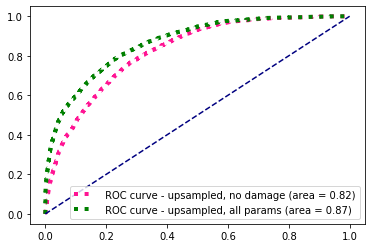

In [267]:
fpr, tpr, _ = roc_curve(target_upsampled.ravel(), y_proba[:,1].ravel())
roc_auc_nd = auc(fpr, tpr)

# Plot all ROC curves
plt.figure()
plt.plot(fpr, tpr,
         label=' ROC curve - upsampled, no damage (area = {0:0.2f})'
               ''.format(roc_auc_nd),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_all, tpr_all,
         label=' ROC curve - upsampled, all params (area = {0:0.2f})'
               ''.format(roc_auc_all),
         color='green', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()

### Down-sampling

In [249]:
for_downsampling = cleaned_dataset.copy()
for_downsampling.head()

,aircraft_category,aircraft_damage,amateur_built,broad_phase_of_flight,engine_type,event_date,far_description,location,make,model,number_of_engines,purpose_of_flight,weather_condition,month,weekday,fatality,state,make_transformed,make_transformed_all,far_transformed
0,Airplane,Substantial,No,MANEUVERING,Reciprocating,2016-12-27,Part 91: General Aviation,"Bridgeport, AL",CESSNA,172,1.0,Personal,VMC,12,1,0,AL,cessna,cessna,Part_91_General_Aviation
1,Airplane,Substantial,No,TAXI,Reciprocating,2016-12-28,Part 91: General Aviation,"Prairie Du Sac, WI",CESSNA,172B,1.0,Personal,VMC,12,2,0,WI,cessna,cessna,Part_91_General_Aviation
2,Airplane,Substantial,No,APPROACH,Reciprocating,2016-12-16,Part 91: General Aviation,"Kewanee, IL",PIPER,PA28R,1.0,Personal,IMC,12,4,0,IL,piper,piper,Part_91_General_Aviation
3,Airplane,Substantial,No,TAKEOFF,Reciprocating,2016-12-16,Part 91: General Aviation,"Ionia, MI",STINSON,108-3,1.0,Personal,VMC,12,4,0,MI,stinson,stinson,Part_91_General_Aviation
4,Airplane,Minor,No,DESCENT,Reciprocating,2016-11-20,Part 135: Air Taxi & Commuter,"McGrath, AK",PIPER,PA 32R-300,1.0,Air_Carrier,VMC,11,6,0,AK,piper,piper,Part_135_Air_Taxi__Commuter


In [250]:
for_downsampling.fatality.value_counts()

0    10772
1     2339
Name: fatality, dtype: int64

In [251]:
# Separate majority and minority classes
df_majority_dn = for_downsampling[for_downsampling.fatality==0]
df_minority_dn = for_downsampling[for_downsampling.fatality==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority_dn, 
                                 replace=False,    # sample without replacement
                                 n_samples=2339,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority_dn])
 
# Display new class counts
df_downsampled.fatality.value_counts()

1    2339
0    2339
Name: fatality, dtype: int64

In [253]:
data_dnsampled = df_downsampled[columns_for_model]
target_dnsampled = df_downsampled['fatality']

In [260]:
data_dnsampled.shape, target_dnsampled.shape

((4678, 13), (4678,))

In [254]:
#One hot encode the training data and show the resulting dataframe with proper column names
ohe_down = OneHotEncoder()

ohe_down.fit(data_dnsampled)
data_ohe_dn = ohe_down.transform(data_dnsampled).toarray()

ohe_dnsampled_df = pd.DataFrame(data_ohe_dn, columns=ohe_down.get_feature_names(data_dnsampled.columns))

ohe_dnsampled_df.head()

,aircraft_category_Airplane,aircraft_category_Balloon,aircraft_category_Glider,aircraft_category_Gyrocraft,aircraft_category_Gyroplane,aircraft_category_Helicopter,aircraft_category_Powered_Parachute,aircraft_category_Rocket,aircraft_category_Ultralight,aircraft_category_Unknown,aircraft_category_Weight-Shift,aircraft_damage_Destroyed,aircraft_damage_Minor,aircraft_damage_NOT-SPECIFIED,aircraft_damage_Substantial,amateur_built_No,amateur_built_Yes,broad_phase_of_flight_APPROACH,broad_phase_of_flight_CLIMB,broad_phase_of_flight_CRUISE,broad_phase_of_flight_DESCENT,broad_phase_of_flight_GO-AROUND,broad_phase_of_flight_LANDING,broad_phase_of_flight_MANEUVERING,broad_phase_of_flight_NOT-SPECIFIED,broad_phase_of_flight_OTHER,broad_phase_of_flight_STANDING,broad_phase_of_flight_TAKEOFF,broad_phase_of_flight_TAXI,broad_phase_of_flight_UNKNOWN,engine_type_None,engine_type_Reciprocating,engine_type_Turbo_Fan,engine_type_Turbo_Jet,engine_type_Turbo_Prop,engine_type_Turbo_Shaft,engine_type_Unknown,engine_type_other,number_of_engines_0.0,number_of_engines_1.0,number_of_engines_2.0,number_of_engines_3.0,number_of_engines_4.0,number_of_engines_Unknown,purpose_of_flight_Aerial_Application,purpose_of_flight_Aerial_Observation,purpose_of_flight_Air_Carrier,purpose_of_flight_Air_Drop,purpose_of_flight_Air_Race_Show,purpose_of_flight_Banner_Tow,purpose_of_flight_Business,purpose_of_flight_Executive_Corporate,purpose_of_flight_External_Load,purpose_of_flight_Ferry,purpose_of_flight_Firefighting,purpose_of_flight_Flight_Test,purpose_of_flight_Glider_Tow,purpose_of_flight_Instructional,purpose_of_flight_Other_Work_Use,purpose_of_flight_Personal,purpose_of_flight_Positioning,purpose_of_flight_Public_Aircraft,purpose_of_flight_Public_Aircraft__Federal,purpose_of_flight_Public_Aircraft__Local,purpose_of_flight_Public_Aircraft__State,purpose_of_flight_Skydiving,purpose_of_flight_Unknown,weather_condition_IMC,weather_condition_UNK,weather_condition_Unknown,weather_condition_VMC,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,state_AK,state_AL,state_AO,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GM,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_ON,state_OR,state_PA,state_PO,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_unknown,make_transformed_aero,make_transformed_aeronca,make_transformed_air,make_transformed_airbus,make_transformed_american,make_transformed_aviat,make_transformed_ayres,make_transformed_beech,make_transformed_bell,make_transformed_bellanca,make_transformed_boeing,make_transformed_cessna,make_transformed_champion,make_transformed_cirrus,make_transformed_dehavilland,make_transformed_diamond,make_transformed_eurocopter,make_transformed_grumman,make_transformed_hughes,make_transformed_luscombe,make_transformed_maule,make_transformed_mcdonnell,make_transformed_mooney,make_transformed_north,make_transformed_other,make_transformed_piper,make_transformed_robinson,make_transformed_rockwell,make_transformed_schweizer,make_transformed_stinson,make_transformed_taylorcraft,make_transformed_unknown,far_transformed_Part_121_Air_Carrier,far_transformed_Part_129_Foreign,far_transformed_Part_133_Rotorcraft_Ext_Load,far_transformed_Part_135_Air_Taxi__Commuter,far_transformed_Part_137_Agricultural,far_transformed_Part_91_General_Aviation,far_transformed_Public_Aircraft,far_transformed_Public_Use,far_transformed_Unknown,far_transformed_other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [255]:
clsf_van_dn = LogisticRegression()

In [256]:
num_of_trials = 1
nested_scores_dn_f1 = np.zeros(num_of_trials)
nested_scores_dn_rocauc = np.zeros(num_of_trials)
nested_scores_dn_prec = np.zeros(num_of_trials)
nested_scores_dn_rec = np.zeros(num_of_trials)

p_grid = {"C": [1, 10, 100]}

for trial in tqdm(range(num_of_trials)):
    cv = KFold(n_splits=5, shuffle=True, random_state=trial)
    score = cross_validate(clsf_van_dn, X=ohe_dnsampled_df, y=target_dnsampled, cv=cv, scoring = scoring)
    y_pred_dn = cross_val_predict(clsf_van_dn, ohe_dnsampled_df, target_dnsampled, cv=cv)
    y_proba_dn = np.array(cross_val_predict(clsf_van_dn, ohe_dnsampled_df, target_dnsampled, cv=cv, method='predict_proba'))
    nested_scores_dn_f1[trial] = score['test_f1'].mean()
    nested_scores_dn_rocauc[trial] = score['test_roc_auc'].mean()
    nested_scores_dn_prec[trial] = score['test_precision'].mean()
    nested_scores_dn_rec[trial] = score['test_recall'].mean()


  0%|          | 0/1 [00:00<?, ?it/s]//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify

Verification of accuracy metrics

In [257]:
print("F1: %0.4f (+/- %0.2f)" % (nested_scores_dn_f1.mean(), nested_scores_dn_f1.std() * 2))
print("ROCAUC: %0.2f (+/- %0.2f)" % (nested_scores_dn_rocauc.mean(), nested_scores_dn_rocauc.std() * 2))
print("Recall: %0.4f (+/- %0.2f)" % (nested_scores_dn_rec.mean(), nested_scores_dn_rec.std() * 2))
print("Precision: %0.4f (+/- %0.2f)" % (nested_scores_dn_prec.mean(), nested_scores_dn_prec.std() * 2))

F1: 0.7452 (+/- 0.00)
ROCAUC: 0.84 (+/- 0.00)
Recall: 0.7395 (+/- 0.00)
Precision: 0.7523 (+/- 0.00)


In [258]:
print(classification_report(target_dnsampled, y_pred_dn))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      2339
           1       0.75      0.74      0.75      2339

    accuracy                           0.75      4678
   macro avg       0.75      0.75      0.75      4678
weighted avg       0.75      0.75      0.75      4678



In [261]:
confusion_matrix(target_dnsampled,y_pred_dn)

array([[1769,  570],
       [ 611, 1728]])

ROC-AUC curve for upsampled and downsampled datapoints

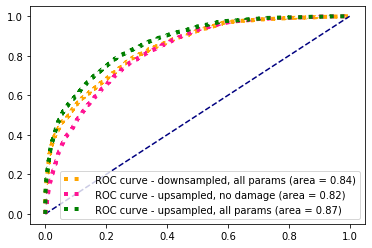

In [269]:
fpr_all_dn, tpr_all_dn, _ = roc_curve(target_dnsampled.ravel(), y_proba_dn[:,1].ravel())
roc_auc_all_dn = auc(fpr_all_dn, tpr_all_dn)

# Plot all ROC curves
plt.figure()
plt.plot(fpr_all_dn, tpr_all_dn,
         label=' ROC curve - downsampled, all params (area = {0:0.2f})'
               ''.format(roc_auc_all_dn),
         color='orange', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot(fpr, tpr,
         label=' ROC curve - upsampled, no damage (area = {0:0.2f})'
               ''.format(roc_auc_nd),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_all, tpr_all,
         label=' ROC curve - upsampled, all params (area = {0:0.2f})'
               ''.format(roc_auc_all),
         color='green', linestyle=':', linewidth=4)
plt.legend()

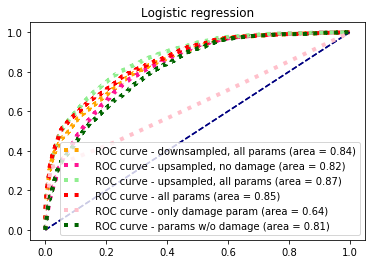

In [648]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr_all_dn, tpr_all_dn,
         label=' ROC curve - downsampled, all params (area = {0:0.2f})'
               ''.format(roc_auc_all_dn),
         color='orange', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot(fpr, tpr,
         label=' ROC curve - upsampled, no damage (area = {0:0.2f})'
               ''.format(roc_auc_nd),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_all, tpr_all,
         label=' ROC curve - upsampled, all params (area = {0:0.2f})'
               ''.format(roc_auc_all),
         color='lightgreen', linestyle=':', linewidth=4)
plt.plot(fpr_log, tpr_log,
         label=' ROC curve - all params (area = {0:0.2f})'
               ''.format(roc_auc_log),
         color='red', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot(fpr_damage, tpr_damage,
         label=' ROC curve - only damage param (area = {0:0.2f})'
               ''.format(roc_auc_damage),
         color='pink', linestyle=':', linewidth=4)

plt.plot(fpr_log_nd, tpr_log_nd,
         label=' ROC curve - params w/o damage (area = {0:0.2f})'
               ''.format(roc_auc_log_nd),
         color='darkgreen', linestyle=':', linewidth=4)
plt.title('Logistic regression')
plt.legend()

### SMOTE - all params

In [538]:
ohe_df.shape, target_df.shape

((13111, 192), (13111,))

In [539]:
target_df.value_counts()

0    10772
1     2339
Name: fatality, dtype: int64

In [781]:
smt = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(ohe_df, target_df, test_size = 0.2)

X_train, y_train = smt.fit_sample(X_train, y_train)

In [543]:
pd.Series(y_train).value_counts()

1    8617
0    8617
dtype: int64

In [464]:
def display_metrics_score(true, preds, proba, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    fpr, tpr, _ = roc_curve(true.ravel(), proba[:,1].ravel())
    roc_auc = auc(fpr, tpr)
    print(classification_report(true, preds))
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    print("RocAUC-Score: {}".format(roc_auc))
    return acc, f1, roc_auc, fpr, tpr

In [782]:
Log_clf = LogisticRegression(random_state = 2).fit(X_train, y_train)
predictions = Log_clf.predict(X_test)
proba = Log_clf.predict_proba(X_test)
display_metrics_score(y_test, predictions, proba, rnd_forest)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.93      0.77      0.84      2160
           1       0.40      0.72      0.52       463

    accuracy                           0.76      2623
   macro avg       0.67      0.75      0.68      2623
weighted avg       0.84      0.76      0.79      2623

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.7624857033930614
F1-Score: 0.5181747873163186
RocAUC-Score: 0.8416896648268137


(0.7624857033930614,
 0.5181747873163186,
 0.8416896648268137,
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.62962963e-04,
        4.62962963e-04, 9.25925926e-04, 9.25925926e-04, 1.38888889e-03,
        1.38888889e-03, 1.85185185e-03, 1.85185185e-03, 2.77777778e-03,
        2.77777778e-03, 3.24074074e-03, 3.24074074e-03, 4.16666667e-03,
        4.16666667e-03, 4.62962963e-03, 4.62962963e-03, 5.09259259e-03,
        5.09259259e-03, 5.55555556e-03, 5.55555556e-03, 6.01851852e-03,
        6.01851852e-03, 6.94444444e-03, 6.94444444e-03, 7.40740741e-03,
        7.40740741e-03, 8.33333333e-03, 8.33333333e-03, 8.79629630e-03,
        8.79629630e-03, 9.25925926e-03, 9.25925926e-03, 9.72222222e-03,
        9.72222222e-03, 1.01851852e-02, 1.01851852e-02, 1.06481481e-02,
        1.06481481e-02, 1.11111111e-02, 1.11111111e-02, 1.15740741e-02,
        1.15740741e-02, 1.25000000e-02, 1.25000000e-02, 1.29629630e-02,
        1.29629630e-02, 1.48148148e-02, 1.48148148e-02, 1.52777778e-02,
 

Upsampling the data-points to even the distribution helped the most with handling class imbalance, therefore this approach will be used in later models

### Random Forest

In [347]:
target_upsampled_rf = target_upsampled.copy()
ohe_upsampled_df_rf = ohe_upsampled_df.copy()
target_upsampled_rf = target_upsampled_rf.reset_index()

In [354]:
target_upsampled_rf = target_upsampled_rf['fatality']

0

In [797]:
kf = KFold(n_splits=5,shuffle=True)

metrics_rf = []

with tqdm_notebook(desc="Split", total=5) as progress:
    for train_index, test_index in tqdm(kf.split(ohe_upsampled_df_rf, target_upsampled_rf)):
        print(train_index,test_index)
        data_train, data_test = ohe_upsampled_df_rf.loc[train_index], ohe_upsampled_df_rf.loc[test_index] 
        target_train, target_test = target_upsampled_rf[train_index], target_upsampled_rf[test_index]
        rnd_forest = RandomForestClassifier(random_state = 42).fit(data_train, target_train)
        predictions = rnd_forest.predict(data_test)
        probab_rf=rnd_forest.predict_proba(data_test)
        print(confusion_matrix(target_test, predictions))
        acc_rf, f1_rf, roc_auc_rf, fpr_rf, tpr_rf = display_metrics_score(target_test, predictions, probab_rf, rnd_forest)
        metrics_rf.append((acc_rf, f1_rf, roc_auc_rf, fpr_rf, tpr_rf))
        progress.update(1)



0it [00:00, ?it/s]

[    0     1     2 ... 21538 21539 21543] [    3     4     5 ... 21540 21541 21542]


//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1it [00:01,  1.29s/it]

[[2019  173]
 [  56 2061]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      2192
           1       0.92      0.97      0.95      2117

    accuracy                           0.95      4309
   macro avg       0.95      0.95      0.95      4309
weighted avg       0.95      0.95      0.95      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9468554188906939
F1-Score: 0.9473684210526315
RocAUC-Score: 0.9878020818607794
[    0     1     2 ... 21541 21542 21543] [   10    13    19

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2it [00:01,  1.10s/it]

[[2015  152]
 [  39 2103]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2167
           1       0.93      0.98      0.96      2142

    accuracy                           0.96      4309
   macro avg       0.96      0.96      0.96      4309
weighted avg       0.96      0.96      0.96      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9556741703411464
F1-Score: 0.9565612917898566
RocAUC-Score: 0.9874650829413445
[    1     2     3 ... 21541 21542 21543] [    0    14    17

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


3it [00:02,  1.02it/s]

[[1933  152]
 [  47 2177]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2085
           1       0.93      0.98      0.96      2224

    accuracy                           0.95      4309
   macro avg       0.96      0.95      0.95      4309
weighted avg       0.95      0.95      0.95      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9538175910884196
F1-Score: 0.9562925543597629
RocAUC-Score: 0.9866719933405792
[    0     1     2 ... 21541 21542 21543] [    9    16    21

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


4it [00:03,  1.12it/s]

[[1978  199]
 [  43 2089]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2177
           1       0.91      0.98      0.95      2132

    accuracy                           0.94      4309
   macro avg       0.95      0.94      0.94      4309
weighted avg       0.95      0.94      0.94      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9438384776050127
F1-Score: 0.9452488687782806
RocAUC-Score: 0.9852943014165663
[    0     3     4 ... 21540 21541 21542] [    1     2     7

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5it [00:04,  1.16it/s]

[[1965  186]
 [  52 2105]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2151
           1       0.92      0.98      0.95      2157

    accuracy                           0.94      4308
   macro avg       0.95      0.94      0.94      4308
weighted avg       0.95      0.94      0.94      4308

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9447539461467038
F1-Score: 0.9464928057553956
RocAUC-Score: 0.9839956488631718


Cross validation mean metrics for random forest model:

In [752]:
print("Accuracy: {}".format(round(np.array(metrics_rf)[:,0].mean(),2)))
print("F1-Score: {}".format(round(np.array(metrics_rf)[:,1].mean(),2)))
print("RocAUC-Score: {}".format(round(np.array(metrics_rf)[:,2].mean(),2)))

Accuracy: 0.95
F1-Score: 0.95
RocAUC-Score: 0.99


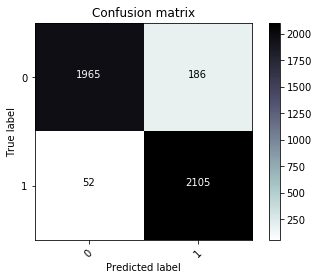

In [798]:
plot_confusion_matrix(confusion_matrix(target_test, predictions),set(target_test), cmap = plt.cm.bone_r)

Comparison of ROC-AUC for random forest and logistic regression

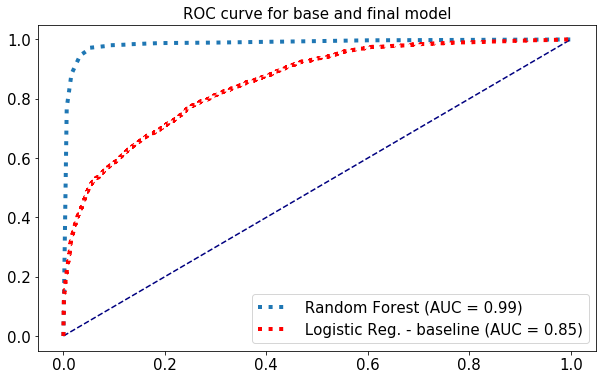

In [794]:
plt.figure(figsize=(10,6))
plt.plot(np.array(metrics_rf)[4,3], np.array(metrics_rf)[tree,4],
             label=' Random Forest (AUC = {0:0.2f})'.format(np.array(metrics_rf)[tree,2]),
              linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot(fpr_log, tpr_log,
         label=' Logistic Reg. - baseline (AUC = {0:0.2f})'
               ''.format(roc_auc_log),
         color='red', linestyle=':', linewidth=4)
plt.title('ROC curve for base and final model', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 15)

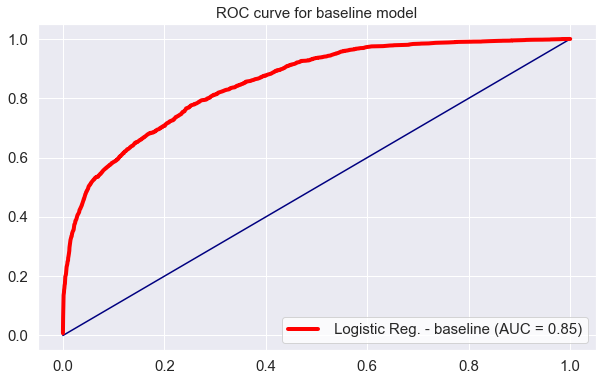

In [813]:
fig = plt.figure(figsize=(10,6))
sns.set()
sns.lineplot([0, 1], [0, 1], color='navy', linestyle='--')
sns.lineplot(fpr_log, tpr_log,
         label=' Logistic Reg. - baseline (AUC = {0:0.2f})'
               ''.format(roc_auc_log),
         color='red', linestyle=':', linewidth=4)
ax = plt.gca()
plt.title('ROC curve for baseline model', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize= 15, facecolor= 'white')
fig.savefig('temp2.png',transparent = True, edgecolor='none')

In [484]:
data_train, data_test, target_train, target_test = train_test_split(ohe_upsampled_df, target_upsampled, test_size = 0.2)
data_train, data_test_2, target_train, target_test_2 = train_test_split(data_train, target_train, test_size = 0.2)

rnd_forest = RandomForestClassifier(random_state = 42).fit(data_train, target_train)
predictions = rnd_forest.predict(data_test)
proba = rnd_forest.predict_proba(data_test)
display_metrics_score(target_test, predictions, proba, rnd_forest)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.97      0.91      0.93      2125
           1       0.91      0.97      0.94      2184

    accuracy                           0.94      4309
   macro avg       0.94      0.94      0.94      4309
weighted avg       0.94      0.94      0.94      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9373404502204687
F1-Score: 0.94
RocAUC-Score: 0.9797342167636285


(0.9373404502204687,
 0.94,
 0.9797342167636285,
 array([0.        , 0.00988235, 0.00988235, 0.02023529, 0.02023529,
        0.02023529, 0.02023529, 0.02117647, 0.02117647, 0.02117647,
        0.03058824, 0.03058824, 0.03105882, 0.03105882, 0.05788235,
        0.05835294, 0.05835294, 0.05835294, 0.05882353, 0.05882353,
        0.05976471, 0.05976471, 0.09364706, 0.09411765, 0.09411765,
        0.09458824, 0.09458824, 0.15529412, 0.15717647, 0.22682353,
        0.22776471, 0.22776471, 0.22823529, 0.22917647, 0.31858824,
        0.31905882, 0.31952941, 0.32047059, 0.32141176, 0.32188235,
        0.46494118, 0.46776471, 0.46870588, 0.46964706, 0.47011765,
        0.47011765, 0.63952941, 0.64047059, 0.64235294, 0.64329412,
        1.        ]),
 array([0.        , 0.69276557, 0.69368132, 0.83745421, 0.83791209,
        0.83974359, 0.84111722, 0.84111722, 0.84203297, 0.84249084,
        0.91620879, 0.91712454, 0.91712454, 0.91758242, 0.94871795,
        0.94871795, 0.9496337 , 0.95009158, 0

In [ ]:
rf_tree_1 = rnd_forest.estimators_[4]

In [818]:
sorted(list(zip(rf_tree_1.feature_importances_, data_train.columns.values)), reverse = True)[:5]

[(0.10620770267632773, 'aircraft_damage_Substantial'),
 (0.06273571962877625, 'broad_phase_of_flight_MANEUVERING'),
 (0.04225556452516712, 'broad_phase_of_flight_LANDING'),
 (0.022437101625487642, 'aircraft_damage_Destroyed'),
 (0.019016472902872082, 'weekday_5')]

In [827]:
for tree in (rnd_forest.estimators_):
    most_important.append(sorted(list(zip(tree.feature_importances_, data_train.columns.values)), reverse = True)[:5])
print(most_important)

[(0.1425090372915408, 'broad_phase_of_flight_LANDING'), (0.11411708896905556, 'aircraft_damage_Destroyed'), (0.027438508444753644, 'broad_phase_of_flight_MANEUVERING'), (0.026568377828515996, 'weather_condition_IMC'), (0.018237923554491386, 'weekday_5'), [(0.16750850418074076, 'aircraft_damage_Destroyed'), (0.049154967178717875, 'broad_phase_of_flight_MANEUVERING'), (0.035024147830570077, 'broad_phase_of_flight_LANDING'), (0.020267594193692114, 'broad_phase_of_flight_TAKEOFF'), (0.01914001185273226, 'weather_condition_VMC')], [(0.1643526884031974, 'broad_phase_of_flight_LANDING'), (0.08923855162488072, 'aircraft_damage_Substantial'), (0.0225704104951866, 'broad_phase_of_flight_MANEUVERING'), (0.018162449034073255, 'aircraft_damage_Destroyed'), (0.0168054619499861, 'weather_condition_IMC')], [(0.1559938737779158, 'aircraft_damage_Destroyed'), (0.06436361097110649, 'broad_phase_of_flight_MANEUVERING'), (0.029222228876347855, 'broad_phase_of_flight_LANDING'), (0.02368805908275339, 'weathe

In [823]:
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


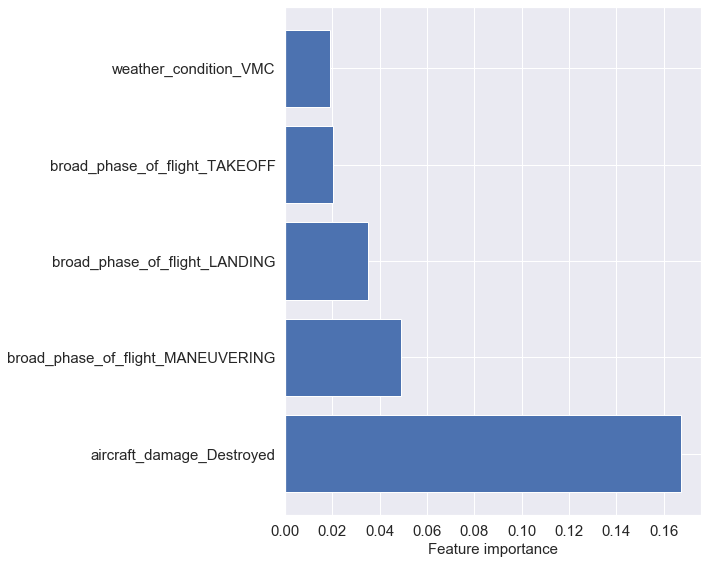

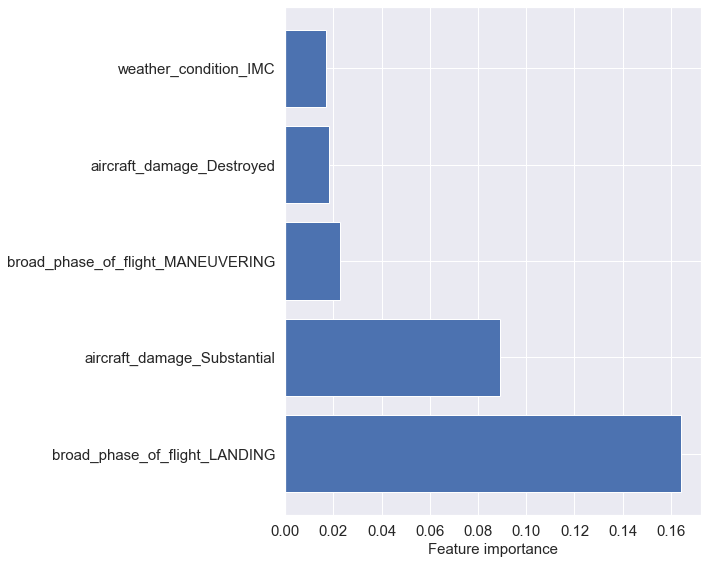

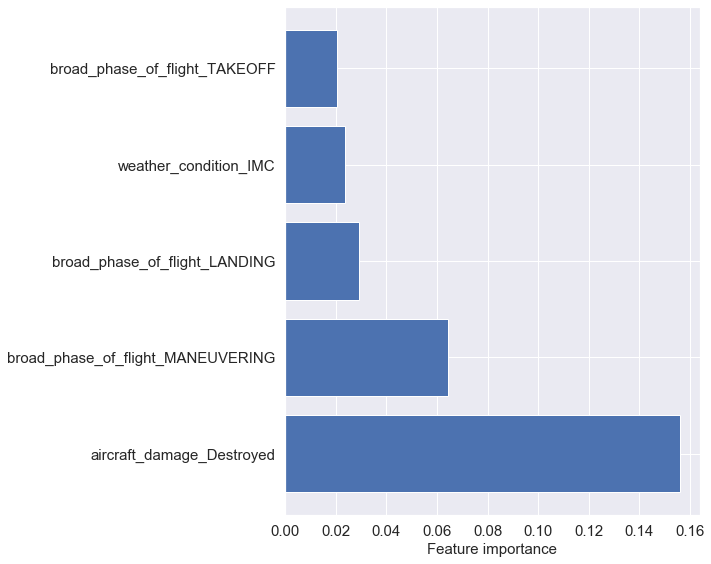

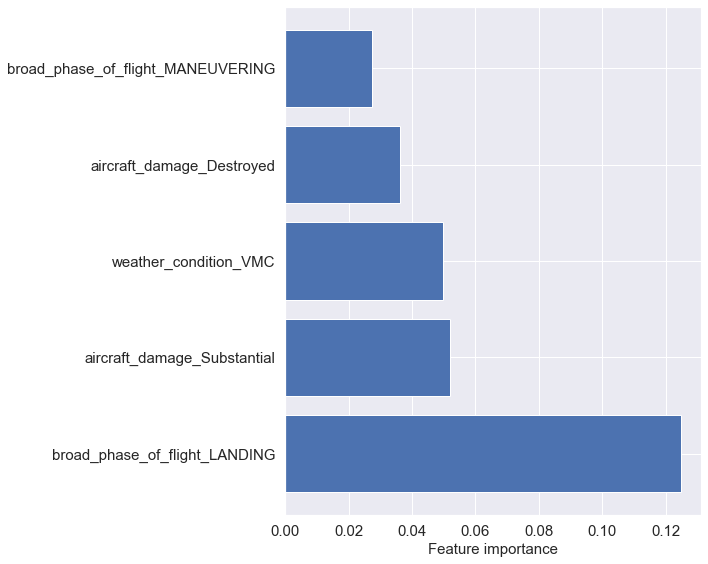

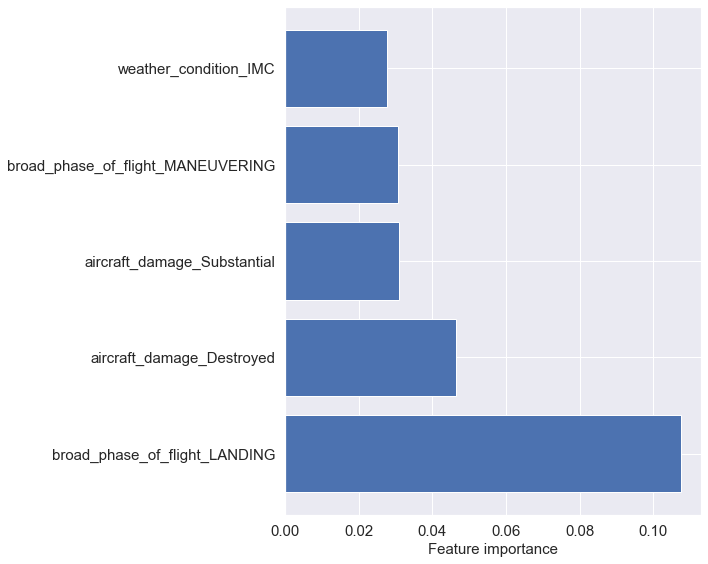

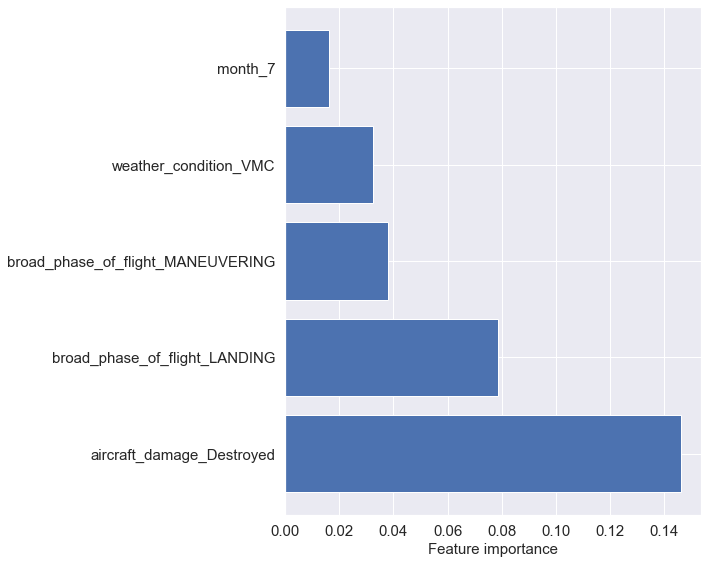

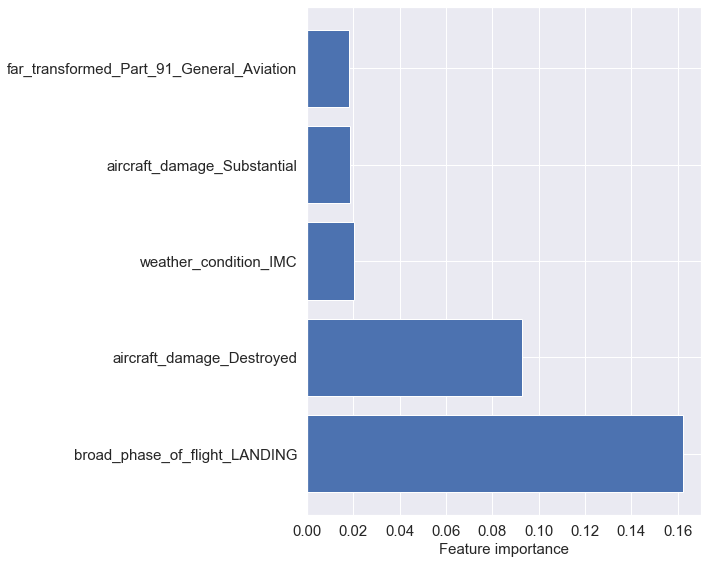

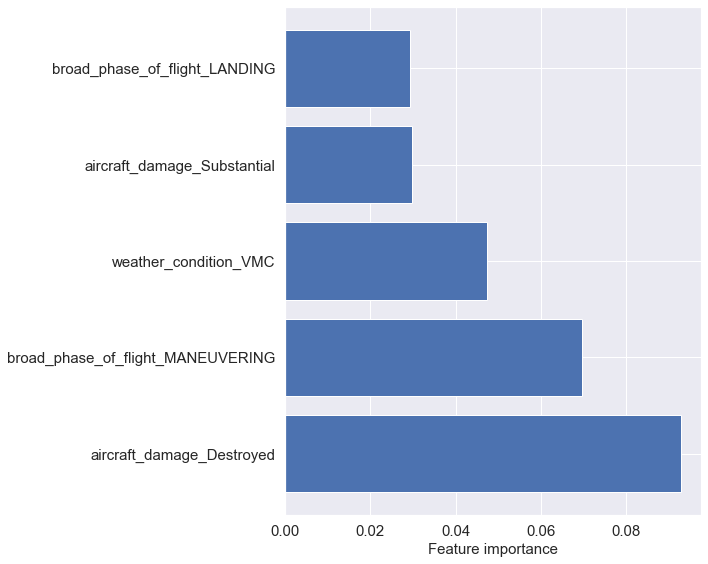

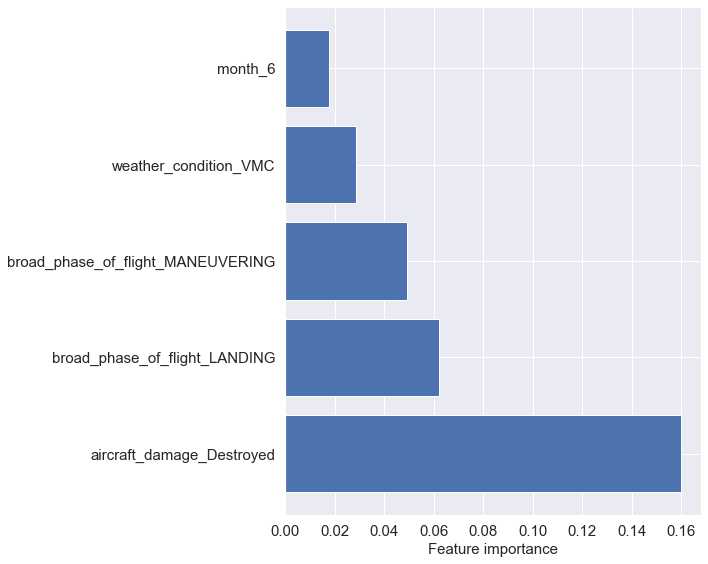

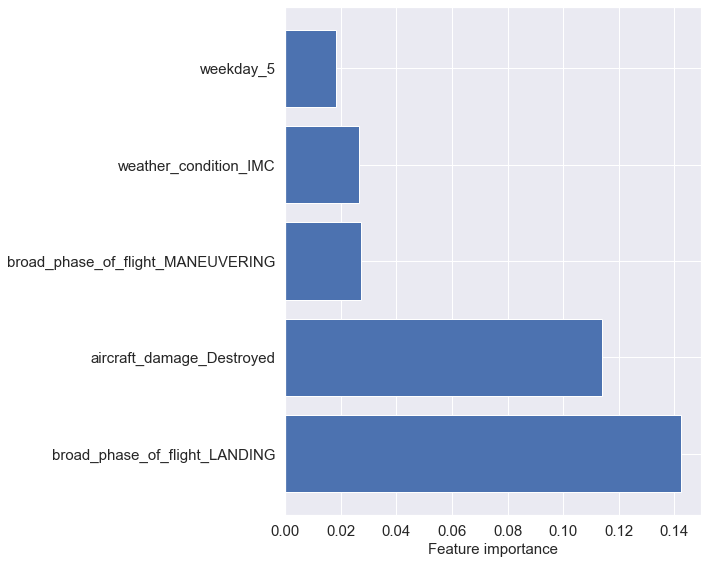

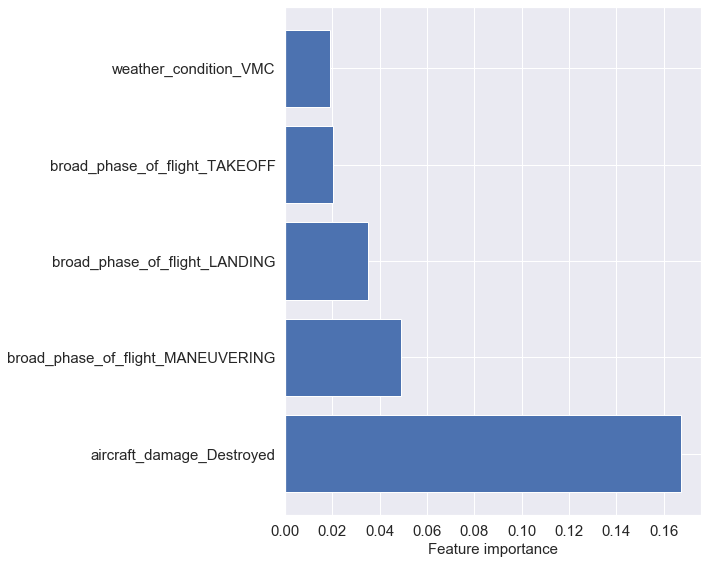

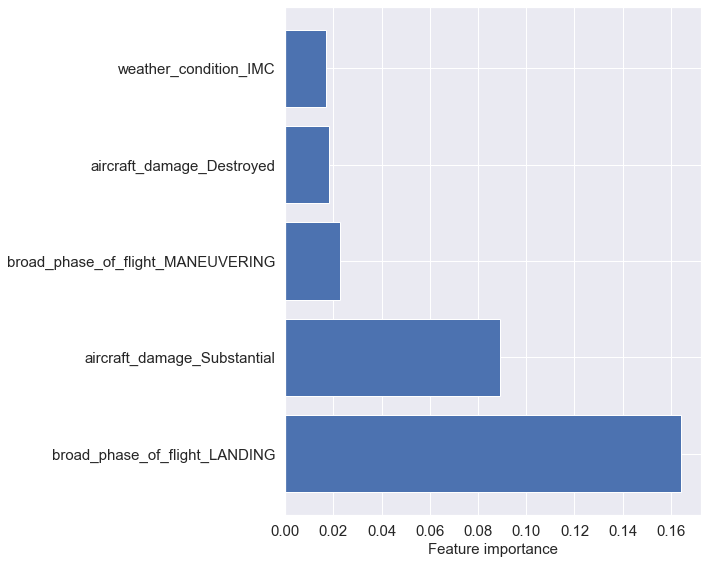

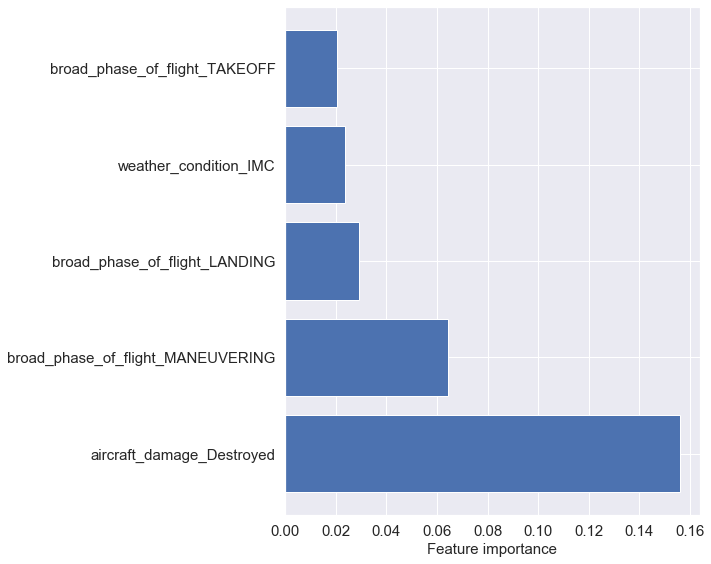

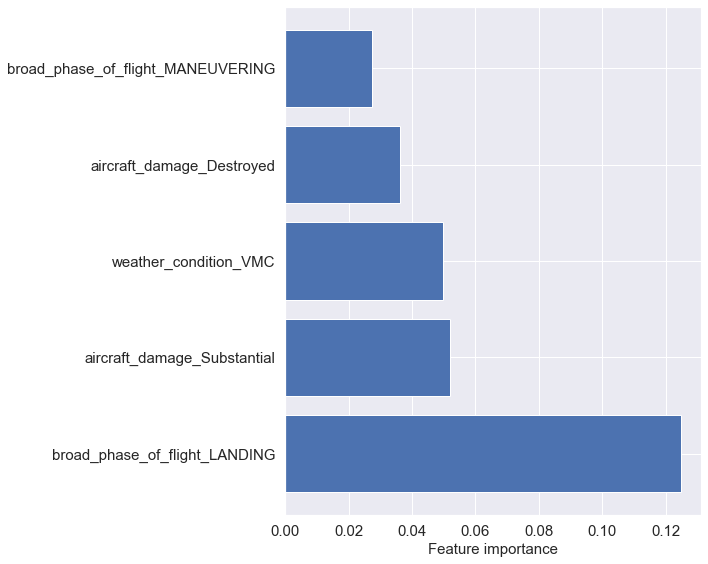

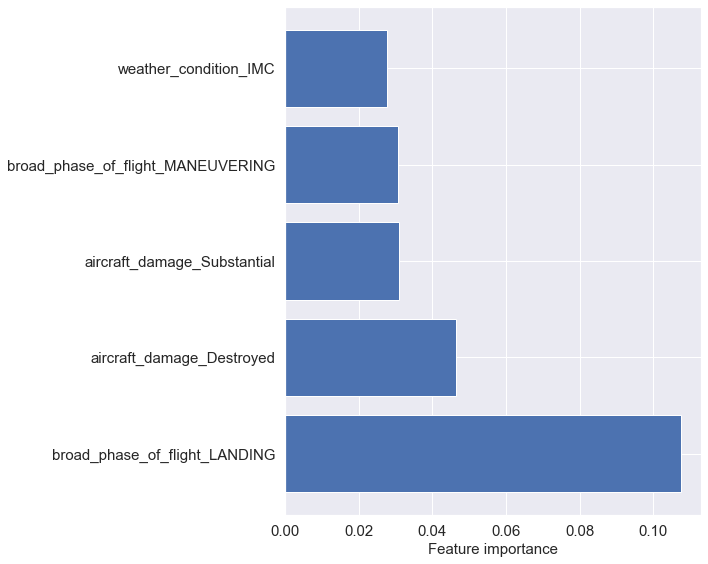

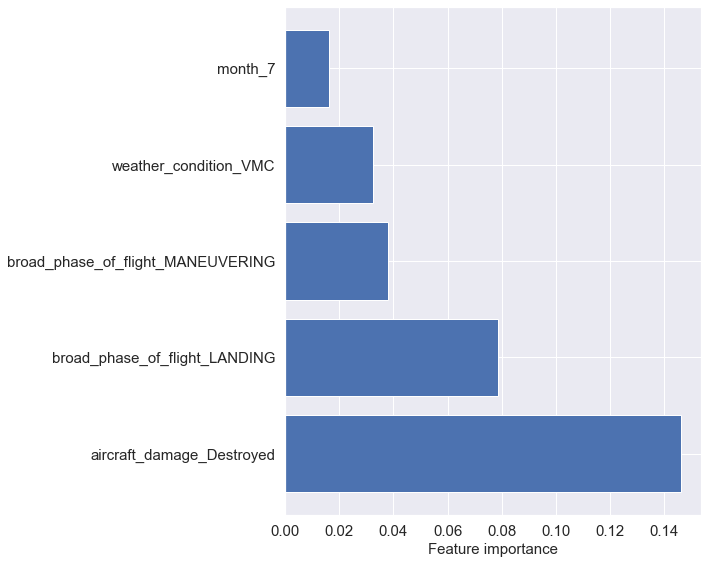

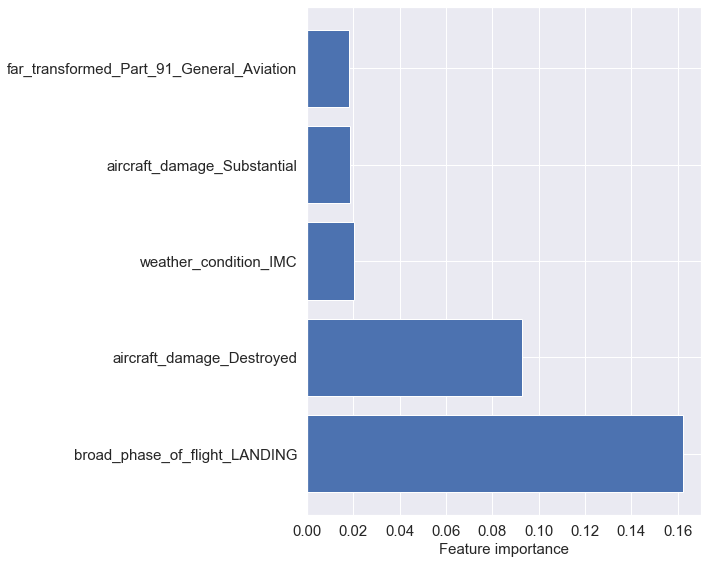

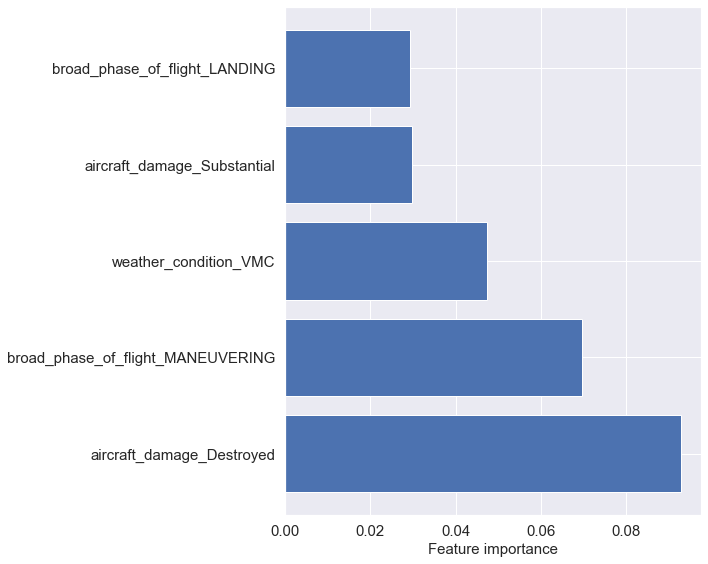

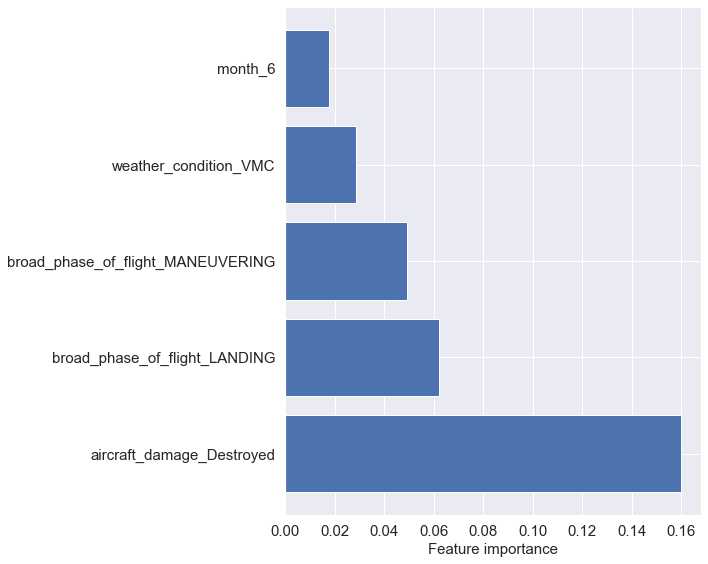

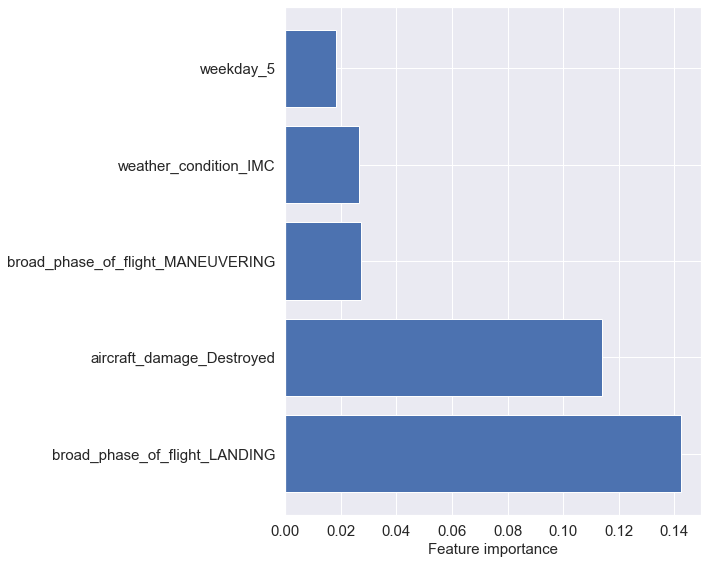

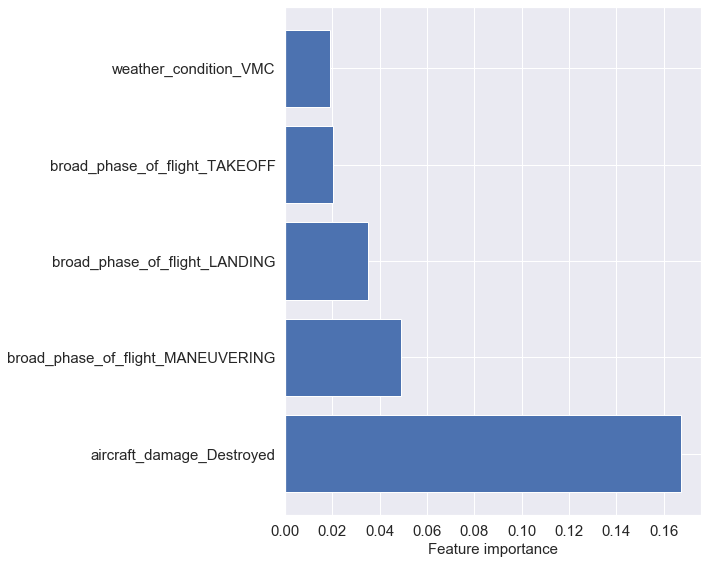

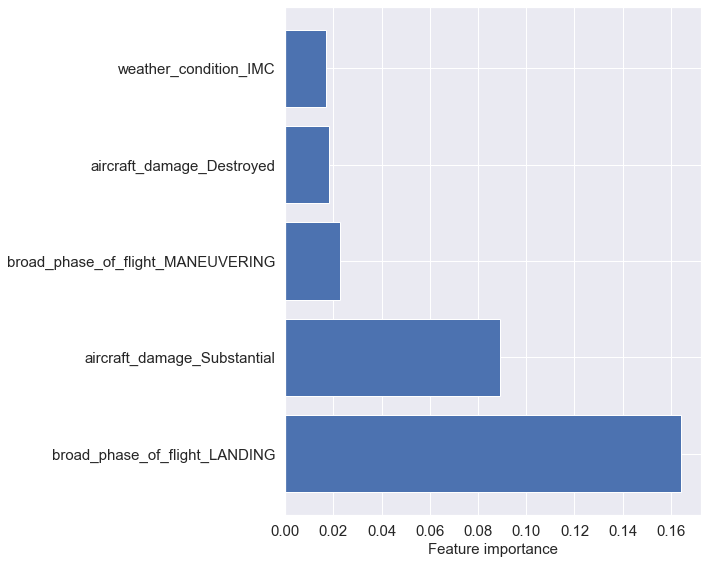

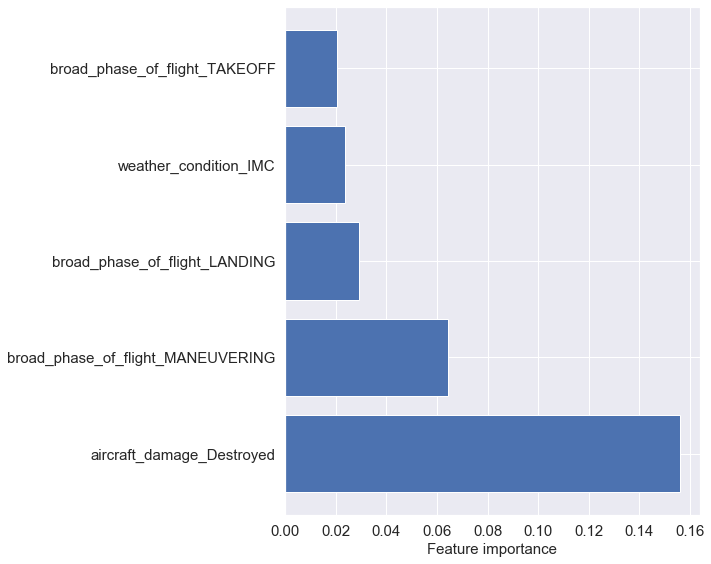

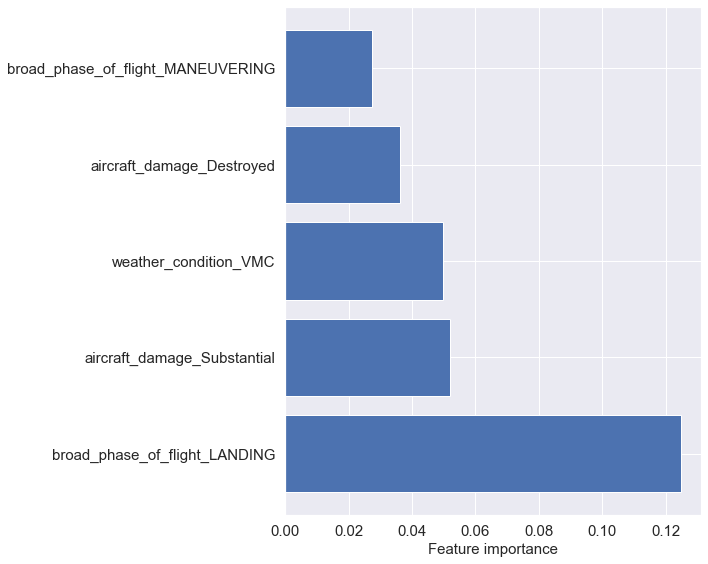

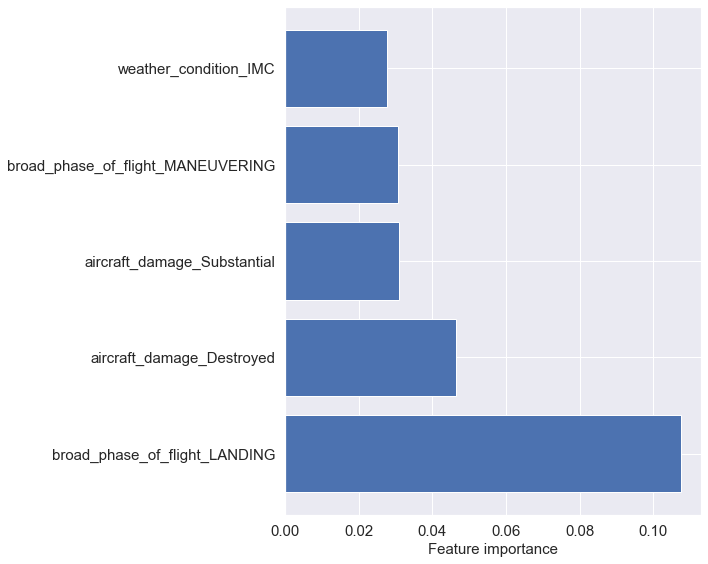

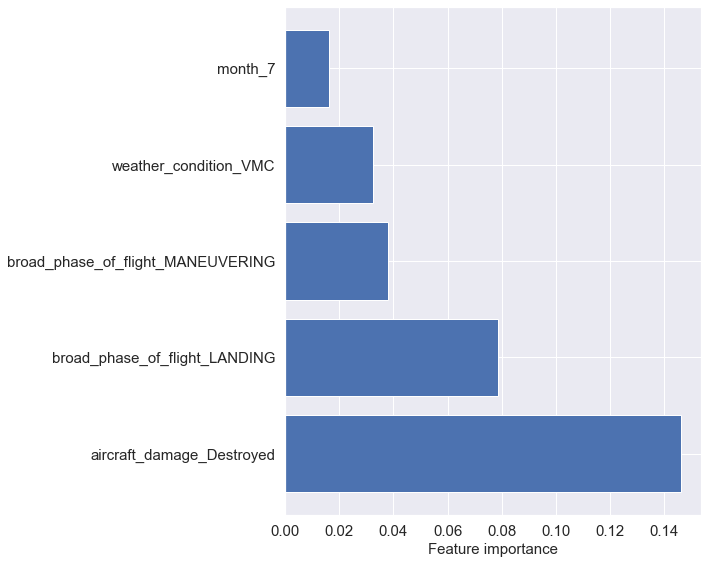

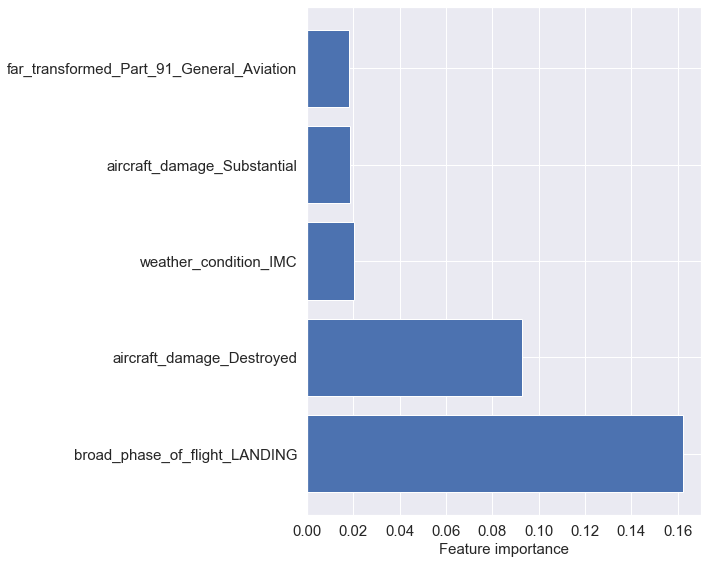

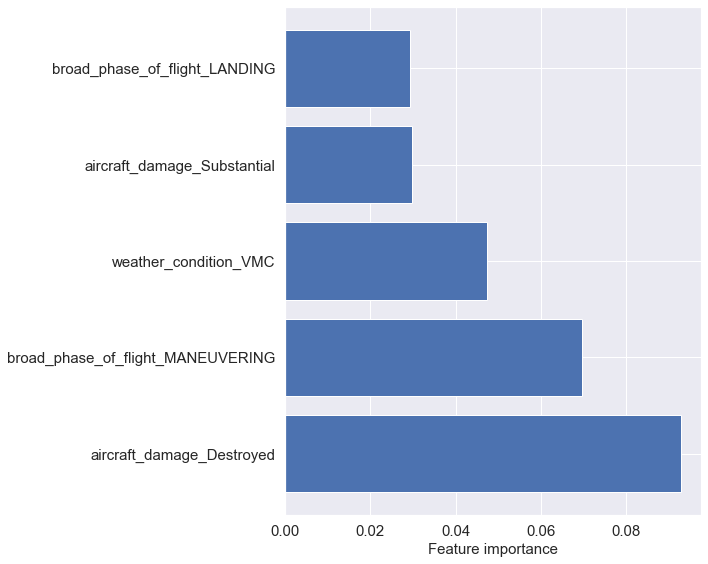

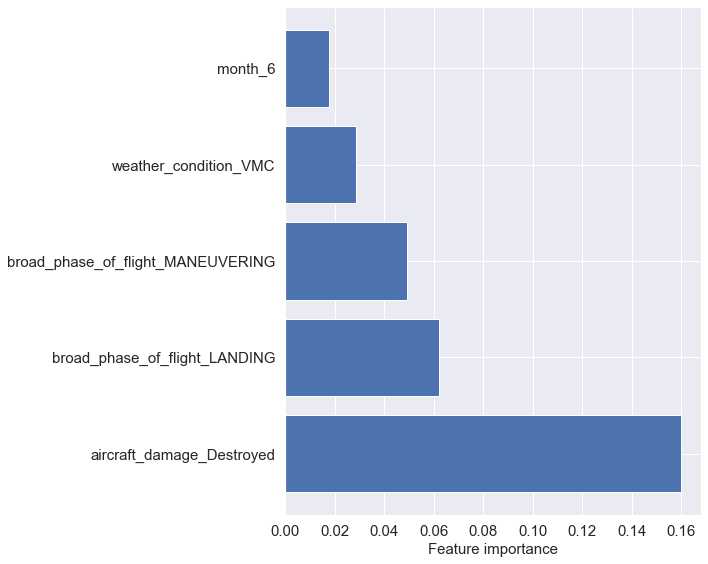

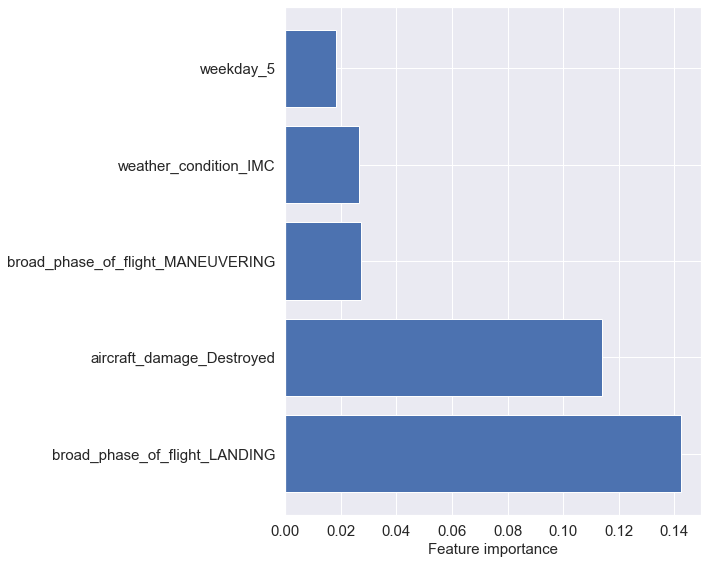

In [890]:
for i in range(len((most_important[5:]))):
    fig = plt.figure(figsize=(10,8))
    plt.barh(range(5), [i[0] for i in (most_important[5:][i])], align='center') 
    plt.yticks(np.arange(5), [i[1] for i in (most_important[5:][i])], fontsize = 15) 
    plt.xticks(fontsize = 15)
    plt.xlabel("Feature importance", fontsize = 15)
    plt.tight_layout()

#### Running GridSearch on model with all features

In [509]:
rf_clf = RandomForestClassifier(random_state = 42)

In [517]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 12, 16, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6]
}

In [2]:
# start = time.time()
# rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3, verbose=10)
# rf_grid_search.fit(data_train, target_train)

# print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
# print(f"Total Runtime for Grid Search on Random Forest Classifier: {time.time() - start :.2f} seconds")
# print("")
# print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Grid Search run for 541.82 seconds, optimal parameters found: 

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}

#### Running model without damage severity

In [401]:
ohe_upsampled_no_damage_df_rf = ohe_upsampled_no_damage_df.copy()

In [354]:
target_upsampled_rf = target_upsampled_rf['fatality']

0

In [666]:
kf = KFold(n_splits=5,shuffle=True)

metrics_rf = []

with tqdm_notebook(desc="Split", total=5) as progress:
    for train_index, test_index in tqdm(kf.split(ohe_upsampled_no_damage_df_rf, target_upsampled_rf)):
        print(train_index,test_index)
        data_train, data_test = ohe_upsampled_no_damage_df_rf.loc[train_index], ohe_upsampled_no_damage_df_rf.loc[test_index] 
        target_train, target_test = target_upsampled_rf[train_index], target_upsampled_rf[test_index]
        rnd_forest = RandomForestClassifier(random_state = 42).fit(data_train, target_train)
        predictions = rnd_forest.predict(data_test)
        probab_rf=rnd_forest.predict_proba(data_test)
        print(confusion_matrix(target_test, predictions))
        acc_rf, f1_rf, roc_auc_rf, fpr_rf, tpr_rf  = display_metrics_score(target_test, predictions, probab_rf, rnd_forest)
        metrics_rf.append((acc_rf, f1_rf, roc_auc_rf, fpr_rf, tpr_rf ))
        progress.update(1)



0it [00:00, ?it/s]//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[    1     2     3 ... 21541 21542 21543] [    0     5     6 ... 21532 21535 21539]




1it [00:00,  1.29it/s]

[[1913  216]
 [  57 2123]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2129
           1       0.91      0.97      0.94      2180

    accuracy                           0.94      4309
   macro avg       0.94      0.94      0.94      4309
weighted avg       0.94      0.94      0.94      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9366442330006962
F1-Score: 0.9395884045142731
RocAUC-Score: 0.9845271286428999
[    0     2     3 ... 21539 21540 21541] [    1     8    10

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2it [00:01,  1.29it/s]

[[1906  246]
 [  40 2117]]
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      2152
           1       0.90      0.98      0.94      2157

    accuracy                           0.93      4309
   macro avg       0.94      0.93      0.93      4309
weighted avg       0.94      0.93      0.93      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9336272917150151
F1-Score: 0.9367256637168141
RocAUC-Score: 0.9820366344209998
[    0     1     2 ... 21540 21542 21543] [    4     9    16

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


3it [00:02,  1.38it/s]

[[1966  222]
 [  56 2065]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2188
           1       0.90      0.97      0.94      2121

    accuracy                           0.94      4309
   macro avg       0.94      0.94      0.94      4309
weighted avg       0.94      0.94      0.94      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9354838709677419
F1-Score: 0.9369328493647913
RocAUC-Score: 0.9842143981961529
[    0     1     4 ... 21541 21542 21543] [    2     3     7

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


4it [00:02,  1.36it/s]

[[1936  229]
 [  64 2080]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2165
           1       0.90      0.97      0.93      2144

    accuracy                           0.93      4309
   macro avg       0.93      0.93      0.93      4309
weighted avg       0.93      0.93      0.93      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9320027848688791
F1-Score: 0.9342016618010331
RocAUC-Score: 0.983685067732929
[    0     1     2 ... 21541 21542 21543] [   11    15    34 

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5it [00:03,  1.27it/s]

[[1904  234]
 [  53 2117]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2138
           1       0.90      0.98      0.94      2170

    accuracy                           0.93      4308
   macro avg       0.94      0.93      0.93      4308
weighted avg       0.94      0.93      0.93      4308

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9333797585886723
F1-Score: 0.9365184693651848
RocAUC-Score: 0.9816828898190739


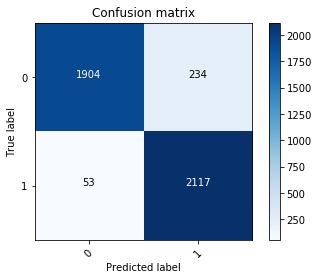

In [670]:
plot_confusion_matrix(confusion_matrix(target_test, predictions),set(target_test))

In [655]:
print("Accuracy: {}".format(np.array(metrics_rf)[:,0].mean()))
print("F1-Score: {}".format(np.array(metrics_rf)[:,1].mean()))
print("RocAUC-Score: {}".format(np.array(metrics_rf)[:,2].mean()))

Accuracy: 0.9350630053958451
F1-Score: 0.9375845673566522
RocAUC-Score: 0.984080017738006


Verification of ROC-AUC for different decision trees in random forest

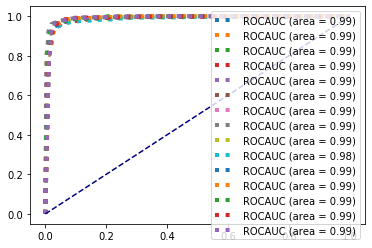

In [508]:
for tree in range(len(metrics_rf)):
    plt.plot(np.array(metrics_rf)[tree,3], np.array(metrics_rf)[tree,4],
             label='ROCAUC (area = {0:0.2f})'.format((np.array(metrics_rf)[tree,2])),
              linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend()

### Boosting algorithms

#### All params upsampled - ADABOOST

In [292]:
#Adaboost - adaptive boosting
adaboost_clf = AdaBoostClassifier()

In [555]:
kf_ada = KFold(n_splits=5,shuffle=True)
metrics_ada = []
with tqdm_notebook(desc="Split", total=5) as progress:
    for train_index, test_index in kf_ada.split(ohe_upsampled_df, target_upsampled_rf):
        data_train, data_test = ohe_upsampled_df.loc[train_index], ohe_upsampled_df.loc[test_index] 
        target_train, target_test = target_upsampled_rf[train_index], target_upsampled_rf[test_index]
        ada_model = adaboost_clf.fit(data_train, target_train)
        predictions_ada = adaboost_clf.predict(data_test)
        probab_ada=adaboost_clf.predict_proba(data_test)
        print(confusion_matrix(target_test, predictions_ada))
        acc_ada, f1_ada, roc_auc_ada, fpr_ada, tpr_ada  = display_metrics_score(target_test, predictions_ada, probab_ada, adaboost_clf)
        metrics_ada.append((acc_ada, f1_ada, roc_auc_ada, fpr_ada, tpr_ada ))
        progress.update(1)

[[1680  466]
 [ 546 1617]]
              precision    recall  f1-score   support

           0       0.75      0.78      0.77      2146
           1       0.78      0.75      0.76      2163

    accuracy                           0.77      4309
   macro avg       0.77      0.77      0.77      4309
weighted avg       0.77      0.77      0.77      4309

Model: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Accuracy: 0.7651427245300534
F1-Score: 0.7616580310880829
RocAUC-Score: 0.860002632600557
[[1657  536]
 [ 447 1669]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      2193
           1       0.76      0.79      0.77      2116

    accuracy                           0.77      4309
   macro avg       0.77      0.77      0.77      4309
weighted avg       0.77      0.77      0.77      4309

Model: AdaBoostClassifier(algorithm='SAMME.R', base_estimato

Accuracy metrics:

In [547]:
print("Accuracy: {}".format(np.array(metrics_ada)[:,0].mean()))
print("F1-Score: {}".format(np.array(metrics_ada)[:,1].mean()))
print("RocAUC-Score: {}".format(np.array(metrics_ada)[:,2].mean()))

Accuracy: 0.7694485188199517
F1-Score: 0.7709635377614964
RocAUC-Score: 0.8604431043270553


Running grid search on AdaBoost

In [548]:
adaboost_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [1.0, 0.5, 0.1]
}

In [3]:
# start = time.time()
# adaboost_grid_search = GridSearchCV(adaboost_clf, adaboost_param_grid, cv=kf_ada, verbose = 10, scoring='f1')
# adaboost_grid_search.fit(data_train, target_train)

# print(f"Testing Accuracy: {adaboost_grid_search.best_score_ :.2%}")
# print(f"Total Runtime for Grid Search on AdaBoost: {time.time() - start :.2f} seconds")
# print("")
# print(f"Optimal Parameters: {adaboost_grid_search.best_params_}")

Total Runtime for Grid Search on AdaBoost: 161.43 seconds

Optimal Parameters: {'learning_rate': 0.1, 'n_estimators': 50}

In [553]:
print('Mean Adaboost Cross-Val Score (k=5):')
print(cross_val_score(adaboost_clf, ohe_upsampled_df, target_upsampled_rf, cv=5, scoring = 'f1').mean())

Mean Adaboost Cross-Val Score (k=5):
0.7564056811620761


In [867]:
adaboost_clf_gr = AdaBoostClassifier(learning_rate = 0.1, n_estimators =  50)
print(cross_val_score(adaboost_clf_gr, ohe_upsampled_df, target_upsampled_rf, cv=5, scoring = 'f1').mean())

0.6824913075269172


In [872]:
adaboost_clf_gr.fit(data_train, target_train).feature_importances_

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.28, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.26, 0.14, 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.1 , 0.  , 0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [874]:
predictions_ada_gr = adaboost_clf_gr.predict(data_test)
print(confusion_matrix(target_test, predictions_ada_gr))

[[1850  301]
 [ 869 1288]]


Verifying feature importance in AdaBoost

In [873]:
most_imp_ada = sorted(list(zip(adaboost_clf_gr.feature_importances_, data_train.columns.values)), reverse = True)[:5]

most_imp_ada

[(0.28, 'aircraft_damage_Destroyed'),
 (0.26, 'broad_phase_of_flight_LANDING'),
 (0.14, 'broad_phase_of_flight_MANEUVERING'),
 (0.1, 'weather_condition_IMC'),
 (0.06, 'weather_condition_VMC')]

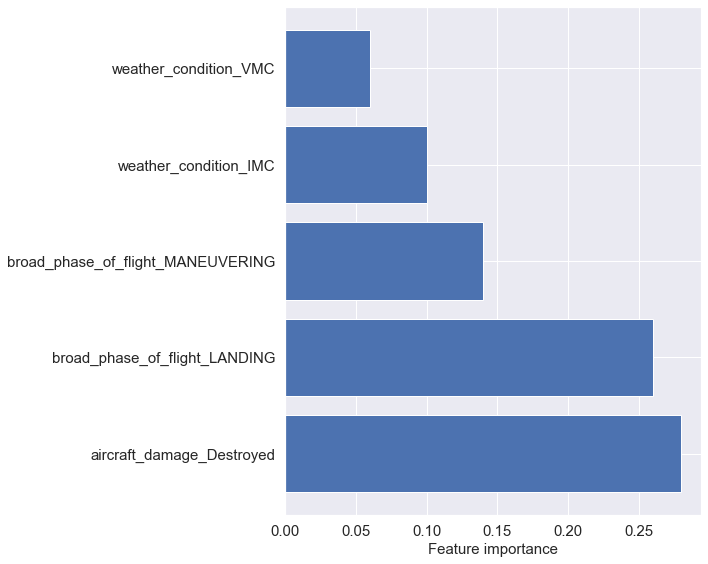

In [875]:
fig = plt.figure(figsize=(10,8))
plt.barh(range(5), [i[0] for i in most_imp_ada], align='center') 
plt.yticks(np.arange(5), [i[1] for i in most_imp_ada], fontsize = 15) 
plt.xticks(fontsize = 15)
plt.xlabel("Feature importance", fontsize = 15)
plt.tight_layout()
fig.savefig('temp4.png',transparent = True)

#### All params upsampled - Gradient Boosting

In [557]:
#gradient boosting
gbt_clf = GradientBoostingClassifier()

In [590]:
kf_gb = KFold(n_splits=5,shuffle=True)
metrics_gb = []
with tqdm_notebook(desc="Split", total=5) as progress:
    for train_index, test_index in kf_gb.split(ohe_upsampled_df, target_upsampled_rf):
        data_train, data_test = ohe_upsampled_df.loc[train_index], ohe_upsampled_df.loc[test_index] 
        target_train, target_test = target_upsampled_rf[train_index], target_upsampled_rf[test_index]
        gb_model = gbt_clf.fit(data_train, target_train)
        predictions_gb = gbt_clf.predict(data_test)
        probab_gb=gbt_clf.predict_proba(data_test)
        print(confusion_matrix(target_test, predictions_gb))
        acc_gb, f1_gb, roc_auc_gb, fpr_gb, tpr_gb  = display_metrics_score(target_test, predictions_gb, probab_gb, gbt_clf)
        metrics_gb.append((acc_gb, f1_gb, roc_auc_gb, fpr_gb, tpr_gb ))
        progress.update(1)

[[1784  421]
 [ 516 1588]]
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      2205
           1       0.79      0.75      0.77      2104

    accuracy                           0.78      4309
   macro avg       0.78      0.78      0.78      4309
weighted avg       0.78      0.78      0.78      4309

Model: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
        

Accuracy metrics for Gradient Boosting:

In [559]:
print("Accuracy: {}".format(np.array(metrics_gb)[:,0].mean()))
print("F1-Score: {}".format(np.array(metrics_gb)[:,1].mean()))
print("RocAUC-Score: {}".format(np.array(metrics_gb)[:,2].mean()))

Accuracy: 0.7788715419972405
F1-Score: 0.7709288736135562
RocAUC-Score: 0.8742349089354711


In [561]:
print('Mean GBT Cross-Val Score (k=5):')
gbt_clf = GradientBoostingClassifier()
print(cross_val_score(gbt_clf, ohe_upsampled_df, target_upsampled_rf, cv=5, scoring = 'f1').mean())

Mean GBT Cross-Val Score (k=5):
0.7650604432939361


Feature importance for Gradient Boosting

In [876]:
most_imp_gbt = sorted(list(zip(gbt_clf.feature_importances_, data_train.columns.values)), reverse = True)[:5]

most_imp_gbt

[(0.3343693146446433, 'broad_phase_of_flight_LANDING'),
 (0.29879833749792467, 'aircraft_damage_Destroyed'),
 (0.07244370588074478, 'broad_phase_of_flight_MANEUVERING'),
 (0.032229147775927926, 'weather_condition_IMC'),
 (0.028364248727653214, 'broad_phase_of_flight_TAXI')]

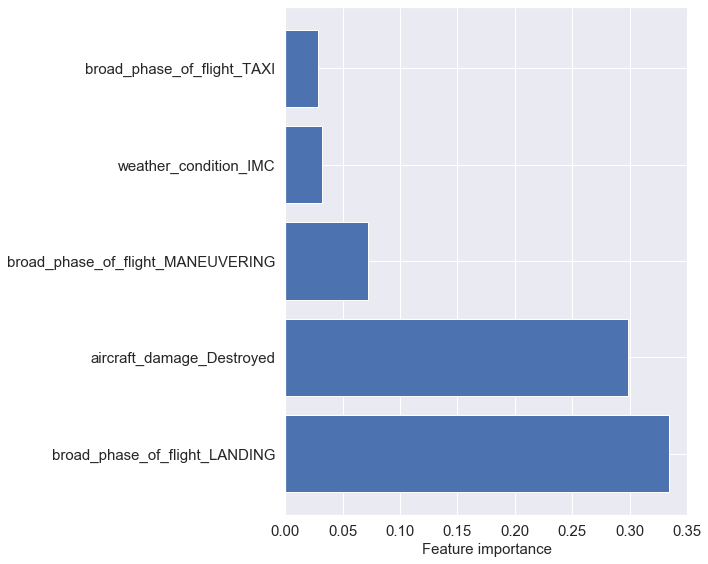

In [877]:
fig = plt.figure(figsize=(10,8))
plt.barh(range(5), [i[0] for i in most_imp_gbt], align='center') 
plt.yticks(np.arange(5), [i[1] for i in most_imp_gbt], fontsize = 15) 
plt.xticks(fontsize = 15)
plt.xlabel("Feature importance", fontsize = 15)
plt.tight_layout()
fig.savefig('temp5.png',transparent = True)

#### All params upsampled - XGBOOST

In [614]:
kf_xgb = KFold(n_splits=5,shuffle=True)
xgbt_model = xgb.XGBClassifier(random_state=42)
metrics_xgb = []
with tqdm_notebook(desc="Split", total=5) as progress:
    for train_index, test_index in kf_xgb.split(ohe_upsampled_df, target_upsampled_rf):
        data_train, data_test = ohe_upsampled_df.loc[train_index], ohe_upsampled_df.loc[test_index] 
        target_train, target_test = target_upsampled_rf[train_index], target_upsampled_rf[test_index]
        xgb_mod = xgbt_model.fit(data_train, target_train)
        predictions_xgb = xgbt_model.predict(data_test)
        probab_xgb= xgbt_model.predict_proba(data_test)
        print(len(probab_xgb), len(predictions_xgb), len(data_test), len(target_test))
        print(confusion_matrix(target_test, predictions_xgb))
        acc_xgb, f1_xgb, roc_auc_xgb, fpr_xgb, tpr_xgb  = display_metrics_score(target_test, predictions_xgb, probab_xgb, xgbt_model)
        metrics_xgb.append((acc_xgb, f1_xgb, roc_auc_xgb, fpr_xgb, tpr_xgb ))
        progress.update(1)

4309 4309 4309 4309
[[1761  439]
 [ 497 1612]]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      2200
           1       0.79      0.76      0.77      2109

    accuracy                           0.78      4309
   macro avg       0.78      0.78      0.78      4309
weighted avg       0.78      0.78      0.78      4309

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 0.7827802274309584
F1-Score: 0.7749999999999999
RocAUC-Score: 0.8751136902452692
4309 4309 4309 4309
[[1767  439]
 [ 498 1605]]
          

Accuracy metrics for XGBoost:

In [615]:
print("Accuracy: {}".format(np.array(metrics_xgb)[:,0].mean()))
print("F1-Score: {}".format(np.array(metrics_xgb)[:,1].mean()))
print("RocAUC-Score: {}".format(np.array(metrics_xgb)[:,2].mean()))

Accuracy: 0.7750181380639042
F1-Score: 0.766968181157572
RocAUC-Score: 0.8701547590865152


In [613]:
print('Mean GBT Cross-Val Score (k=5):')
clf = xgb.XGBClassifier()
print(cross_val_score(clf, ohe_upsampled_df, target_upsampled_rf, cv=5,scoring= 'roc_auc').mean())

Mean GBT Cross-Val Score (k=5):
0.8628862249118623


GridSearch for XGBoost:

In [626]:
xgb_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [1.0, 0.5, 0.1],
    'max_depth': [3, 10, 15]
}

In [4]:
# start = time.time()
# xgb_grid_search = GridSearchCV(clf, xgb_param_grid, cv=kf_xgb, verbose = 10, scoring='roc_auc')
# xgb_grid_search.fit(ohe_upsampled_df, target_upsampled_rf)

# print(f"Testing Accuracy: {xgb_grid_search.best_score_ :.2%}")
# print(f"Total Runtime for Grid Search on XGBoost: {time.time() - start :.2f} seconds")
# print("")
# print(f"Optimal Parameters: {xgb_grid_search.best_params_}")

Testing Accuracy: 97.71%

Total Runtime for Grid Search on XGBoost: 8491.61 seconds

Optimal Parameters: {'learning_rate': 0.5, 'max_depth': 15, 'n_estimators': 250}

In [ ]:
kf_xgb = KFold(n_splits=5,shuffle=True)
xgbt_model = xgb.XGBClassifier(learning_rate=0.5, max_depth= 15, n_estimators=250, random_state=42)
metrics_xgb = []
with tqdm_notebook(desc="Split", total=5) as progress:
    for train_index, test_index in kf_xgb.split(ohe_upsampled_df, target_upsampled_rf):
        data_train, data_test = ohe_upsampled_df.loc[train_index], ohe_upsampled_df.loc[test_index] 
        target_train, target_test = target_upsampled_rf[train_index], target_upsampled_rf[test_index]
        xgb_mod = xgbt_model.fit(data_train, target_train)
        predictions_xgb = xgbt_model.predict(data_test)
        probab_xgb= xgbt_model.predict_proba(data_test)
        print(len(probab_xgb), len(predictions_xgb), len(data_test), len(target_test))
        print(confusion_matrix(target_test, predictions_xgb))
        xgb_most_imp = sorted(list(zip(xgb_model.feature_importances_, data_train.columns.values)), reverse = True, key=lambda tup: tup[0])[:5]
        acc_xgb, f1_xgb, roc_auc_xgb, fpr_xgb, tpr_xgb  = display_metrics_score(target_test, predictions_xgb, probab_xgb, xgbt_model)
        metrics_xgb.append((acc_xgb, f1_xgb, roc_auc_xgb, fpr_xgb, tpr_xgb ))
        progress.update(1)

Accuracy metrics for XGBoost after grid search:

In [629]:
print("Accuracy: {}".format(np.array(metrics_xgb)[:,0].mean()))
print("F1-Score: {}".format(np.array(metrics_xgb)[:,1].mean()))
print("RocAUC-Score: {}".format(np.array(metrics_xgb)[:,2].mean()))

Accuracy: 0.9388693268585777
F1-Score: 0.9415797806738411
RocAUC-Score: 0.9769536422586278


In [ ]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(xgbt_model, ohe_upsampled_df, target_upsampled_rf, cv=5,scoring= 'roc_auc').mean())

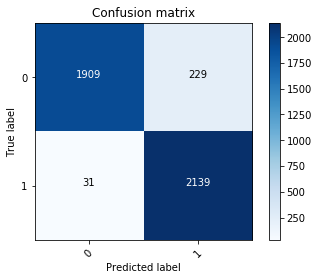

In [677]:
plot_confusion_matrix(confusion_matrix(target_test,predictions_xgb),set(target_test))

Feature importance for XGBoost:

In [919]:
xgb_most_imp_2 = sorted(list(zip(xgb_model.feature_importances_, data_train.columns.values)), key=lambda tup: tup[0], reverse = True)

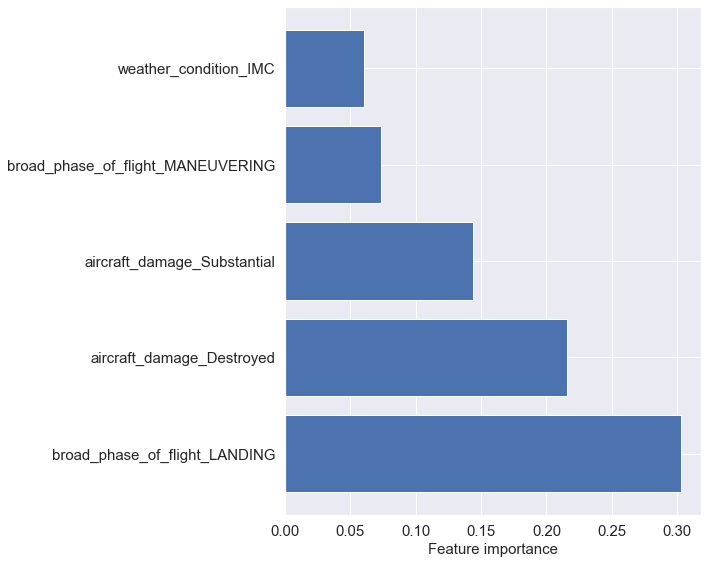

In [905]:
fig = plt.figure(figsize=(10,8))
plt.barh(range(5), [i[0] for i in xgb_most_imp], align='center') 
plt.yticks(np.arange(5), [i[1] for i in xgb_most_imp], fontsize = 15) 
plt.xticks(fontsize = 15)
plt.xlabel("Feature importance", fontsize = 15)
plt.tight_layout()
fig.savefig('temp3.png',transparent = True)

### Adding time variable to verify if this will improve accuracy of the models

In [679]:
cleaned_dataset_with_date = pd.read_csv('cleaned_dataset2008-2017_plus_time.csv')
cleaned_dataset_with_date.head()

,aircraft_category,aircraft_damage,amateur_built,broad_phase_of_flight,engine_type,event_date,far_description,location,make,model,number_of_engines,purpose_of_flight,weather_condition,month,weekday,fatality,state,make_transformed,make_transformed_all,far_transformed,time_var
0,Airplane,Substantial,No,MANEUVERING,Reciprocating,2016-12-27,Part 91: General Aviation,"Bridgeport, AL",CESSNA,172,1.0,Personal,VMC,12,1,0,AL,cessna,cessna,Part_91_General_Aviation,0.723299
1,Airplane,Substantial,No,TAXI,Reciprocating,2016-12-28,Part 91: General Aviation,"Prairie Du Sac, WI",CESSNA,172B,1.0,Personal,VMC,12,2,0,WI,cessna,cessna,Part_91_General_Aviation,0.723795
2,Airplane,Substantial,No,APPROACH,Reciprocating,2016-12-16,Part 91: General Aviation,"Kewanee, IL",PIPER,PA28R,1.0,Personal,IMC,12,4,0,IL,piper,piper,Part_91_General_Aviation,0.717834
3,Airplane,Substantial,No,TAKEOFF,Reciprocating,2016-12-16,Part 91: General Aviation,"Ionia, MI",STINSON,108-3,1.0,Personal,VMC,12,4,0,MI,stinson,stinson,Part_91_General_Aviation,0.717834
4,Airplane,Minor,No,DESCENT,Reciprocating,2016-11-20,Part 135: Air Taxi & Commuter,"McGrath, AK",PIPER,PA 32R-300,1.0,Air_Carrier,VMC,11,6,0,AK,piper,piper,Part_135_Air_Taxi__Commuter,0.704918


In [687]:
data_time = data.copy()

In [688]:
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13111 entries, 0 to 13110
Data columns (total 13 columns):
aircraft_category        13111 non-null object
aircraft_damage          13111 non-null object
amateur_built            13111 non-null object
broad_phase_of_flight    13111 non-null object
engine_type              13111 non-null object
number_of_engines        13111 non-null object
purpose_of_flight        13111 non-null object
weather_condition        13111 non-null object
month                    13111 non-null object
weekday                  13111 non-null object
state                    13111 non-null object
make_transformed         13111 non-null object
far_transformed          13111 non-null object
dtypes: object(13)
memory usage: 1.3+ MB


In [689]:
#One hot encode the training data and show the resulting dataframe with proper column names
ohe_t = OneHotEncoder()

ohe_t.fit(data_time)
data_ohe_t = ohe_t.transform(data_time).toarray()

#Creating this dataframe is not necessary its only to show the result of the ohe
ohe_df_t = pd.DataFrame(data_ohe_t, columns=ohe_t.get_feature_names(data_time.columns))

ohe_df_t['time_var'] = cleaned_dataset_with_date['time_var'].copy()
ohe_df_t.head()

,aircraft_category_Airplane,aircraft_category_Balloon,aircraft_category_Glider,aircraft_category_Gyrocraft,aircraft_category_Gyroplane,aircraft_category_Helicopter,aircraft_category_Powered_Parachute,aircraft_category_Rocket,aircraft_category_Ultralight,aircraft_category_Unknown,aircraft_category_Weight-Shift,aircraft_damage_Destroyed,aircraft_damage_Minor,aircraft_damage_NOT-SPECIFIED,aircraft_damage_Substantial,amateur_built_No,amateur_built_Yes,broad_phase_of_flight_APPROACH,broad_phase_of_flight_CLIMB,broad_phase_of_flight_CRUISE,broad_phase_of_flight_DESCENT,broad_phase_of_flight_GO-AROUND,broad_phase_of_flight_LANDING,broad_phase_of_flight_MANEUVERING,broad_phase_of_flight_NOT-SPECIFIED,broad_phase_of_flight_OTHER,broad_phase_of_flight_STANDING,broad_phase_of_flight_TAKEOFF,broad_phase_of_flight_TAXI,broad_phase_of_flight_UNKNOWN,engine_type_None,engine_type_Reciprocating,engine_type_Turbo_Fan,engine_type_Turbo_Jet,engine_type_Turbo_Prop,engine_type_Turbo_Shaft,engine_type_Unknown,engine_type_other,number_of_engines_0.0,number_of_engines_1.0,number_of_engines_2.0,number_of_engines_3.0,number_of_engines_4.0,number_of_engines_Unknown,purpose_of_flight_Aerial_Application,purpose_of_flight_Aerial_Observation,purpose_of_flight_Air_Carrier,purpose_of_flight_Air_Drop,purpose_of_flight_Air_Race_Show,purpose_of_flight_Banner_Tow,purpose_of_flight_Business,purpose_of_flight_Executive_Corporate,purpose_of_flight_External_Load,purpose_of_flight_Ferry,purpose_of_flight_Firefighting,purpose_of_flight_Flight_Test,purpose_of_flight_Glider_Tow,purpose_of_flight_Instructional,purpose_of_flight_Other_Work_Use,purpose_of_flight_Personal,purpose_of_flight_Positioning,purpose_of_flight_Public_Aircraft,purpose_of_flight_Public_Aircraft__Federal,purpose_of_flight_Public_Aircraft__Local,purpose_of_flight_Public_Aircraft__State,purpose_of_flight_Skydiving,purpose_of_flight_Unknown,weather_condition_IMC,weather_condition_UNK,weather_condition_Unknown,weather_condition_VMC,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,state_AK,state_AL,state_AO,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GM,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_ON,state_OR,state_PA,state_PO,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_unknown,make_transformed_aero,make_transformed_aeronca,make_transformed_air,make_transformed_airbus,make_transformed_american,make_transformed_aviat,make_transformed_ayres,make_transformed_beech,make_transformed_bell,make_transformed_bellanca,make_transformed_boeing,make_transformed_cessna,make_transformed_champion,make_transformed_cirrus,make_transformed_dehavilland,make_transformed_diamond,make_transformed_eurocopter,make_transformed_grumman,make_transformed_hughes,make_transformed_luscombe,make_transformed_maule,make_transformed_mcdonnell,make_transformed_mooney,make_transformed_north,make_transformed_other,make_transformed_piper,make_transformed_robinson,make_transformed_rockwell,make_transformed_schweizer,make_transformed_stinson,make_transformed_taylorcraft,make_transformed_unknown,far_transformed_Part_121_Air_Carrier,far_transformed_Part_129_Foreign,far_transformed_Part_133_Rotorcraft_Ext_Load,far_transformed_Part_135_Air_Taxi__Commuter,far_transformed_Part_137_Agricultural,far_transformed_Part_91_General_Aviation,far_transformed_Public_Aircraft,far_transformed_Public_Use,far_transformed_Unknown,far_transformed_other,time_var
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Base logistic regression with time variable:

In [691]:
kf = KFold(n_splits=5,shuffle=True)

metrics_log = []

with tqdm_notebook(desc="Split", total=5) as progress:
    for train_index, test_index in tqdm(kf.split(ohe_df_t, target_df)):
        print(train_index,test_index)
        data_train, data_test = ohe_df_t.loc[train_index], ohe_df_t.loc[test_index] 
        target_train, target_test = target_df[train_index], target_df[test_index]
        clsf_log = LogisticRegression(random_state=2, solver='liblinear', multi_class='auto').fit(data_train, target_train)
        predictions = clsf_log.predict(data_test)
        probab=clsf_log.predict_proba(data_test)
        print(confusion_matrix(target_test, predictions))
        accuracy = clsf_log.score(data_test, target_test) 
        print (target_test.shape,probab.shape)
        target_names = list(target_df.unique())
        print(classification_report(target_test, predictions))
        acc_log, f1_log, roc_auc_log, fpr_log, tpr_log = display_metrics_score(target_test, predictions, probab, clsf_log)
        metrics_log.append((acc_log, f1_log, roc_auc_log, fpr_log, tpr_log))
        progress.update(1)



0it [00:00, ?it/s]

1it [00:00,  6.79it/s]

[    0     1     2 ... 13106 13107 13108] [   10    17    19 ... 13105 13109 13110]
[[2032   72]
 [ 296  223]]
(2623,) (2623, 2)
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2104
           1       0.76      0.43      0.55       519

    accuracy                           0.86      2623
   macro avg       0.81      0.70      0.73      2623
weighted avg       0.85      0.86      0.84      2623

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2104
           1       0.76      0.43      0.55       519

    accuracy                           0.86      2623
   macro avg       0.81      0.70      0.73      2623
weighted avg       0.85      0.86      0.84      2623

Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2'



2it [00:00,  6.35it/s]

3it [00:00,  6.24it/s]

[[2095   65]
 [ 258  204]]
(2622,) (2622, 2)
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2160
           1       0.76      0.44      0.56       462

    accuracy                           0.88      2622
   macro avg       0.82      0.71      0.74      2622
weighted avg       0.87      0.88      0.86      2622

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2160
           1       0.76      0.44      0.56       462

    accuracy                           0.88      2622
   macro avg       0.82      0.71      0.74      2622
weighted avg       0.87      0.88      0.86      2622

Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2, solver='liblinear', tol=0.0001, verbose=0,
    



4it [00:00,  6.41it/s]

[    0     1     2 ... 13108 13109 13110] [    4     7     8 ... 13086 13093 13104]
[[2106   60]
 [ 287  169]]
(2622,) (2622, 2)
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2166
           1       0.74      0.37      0.49       456

    accuracy                           0.87      2622
   macro avg       0.81      0.67      0.71      2622
weighted avg       0.86      0.87      0.85      2622

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2166
           1       0.74      0.37      0.49       456

    accuracy                           0.87      2622
   macro avg       0.81      0.67      0.71      2622
weighted avg       0.86      0.87      0.85      2622

Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2'



5it [00:00,  6.39it/s]

[[2115   60]
 [ 268  179]]
(2622,) (2622, 2)
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2175
           1       0.75      0.40      0.52       447

    accuracy                           0.87      2622
   macro avg       0.82      0.69      0.72      2622
weighted avg       0.86      0.87      0.86      2622

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2175
           1       0.75      0.40      0.52       447

    accuracy                           0.87      2622
   macro avg       0.82      0.69      0.72      2622
weighted avg       0.86      0.87      0.86      2622

Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2, solver='liblinear', tol=0.0001, verbose=0,
    

In [692]:
print("Accuracy: {}".format(np.array(metrics_log)[:,0].mean()))
print("F1-Score: {}".format(np.array(metrics_log)[:,1].mean()))
print("RocAUC-Score: {}".format(np.array(metrics_log)[:,2].mean()))

Accuracy: 0.8692708083424427
F1-Score: 0.5276028591218139
RocAUC-Score: 0.8552182664077721


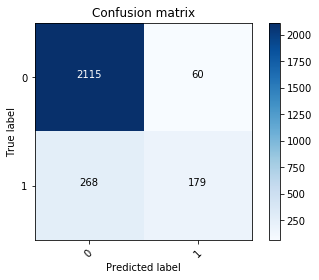

In [693]:
plot_confusion_matrix(confusion_matrix(target_test,predictions),set(target_test))

In [702]:
for_upsampling_t = cleaned_dataset_with_date.copy()
for_upsampling_t.head()

,aircraft_category,aircraft_damage,amateur_built,broad_phase_of_flight,engine_type,event_date,far_description,location,make,model,number_of_engines,purpose_of_flight,weather_condition,month,weekday,fatality,state,make_transformed,make_transformed_all,far_transformed,time_var
0,Airplane,Substantial,No,MANEUVERING,Reciprocating,2016-12-27,Part 91: General Aviation,"Bridgeport, AL",CESSNA,172,1.0,Personal,VMC,12,1,0,AL,cessna,cessna,Part_91_General_Aviation,0.723299
1,Airplane,Substantial,No,TAXI,Reciprocating,2016-12-28,Part 91: General Aviation,"Prairie Du Sac, WI",CESSNA,172B,1.0,Personal,VMC,12,2,0,WI,cessna,cessna,Part_91_General_Aviation,0.723795
2,Airplane,Substantial,No,APPROACH,Reciprocating,2016-12-16,Part 91: General Aviation,"Kewanee, IL",PIPER,PA28R,1.0,Personal,IMC,12,4,0,IL,piper,piper,Part_91_General_Aviation,0.717834
3,Airplane,Substantial,No,TAKEOFF,Reciprocating,2016-12-16,Part 91: General Aviation,"Ionia, MI",STINSON,108-3,1.0,Personal,VMC,12,4,0,MI,stinson,stinson,Part_91_General_Aviation,0.717834
4,Airplane,Minor,No,DESCENT,Reciprocating,2016-11-20,Part 135: Air Taxi & Commuter,"McGrath, AK",PIPER,PA 32R-300,1.0,Air_Carrier,VMC,11,6,0,AK,piper,piper,Part_135_Air_Taxi__Commuter,0.704918


In [703]:
for_upsampling_t['fatality'].value_counts()

0    10772
1     2339
Name: fatality, dtype: int64

In [704]:
# Separate majority and minority classes
df_majority_t = for_upsampling_t[for_upsampling['fatality']==0]
df_minority_t = for_upsampling_t[for_upsampling['fatality']==1]

# Upsample minority class
df_minority_upsampled_t = resample(df_minority_t, 
                                 replace=True,     # sample with replacement
                                 n_samples=10772,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled_t = pd.concat([df_majority_t, df_minority_upsampled_t])
 
# Display new class counts
df_upsampled_t.fatality.value_counts()

1    10772
0    10772
Name: fatality, dtype: int64

In [705]:
df_upsampled_t.head()

,aircraft_category,aircraft_damage,amateur_built,broad_phase_of_flight,engine_type,event_date,far_description,location,make,model,number_of_engines,purpose_of_flight,weather_condition,month,weekday,fatality,state,make_transformed,make_transformed_all,far_transformed,time_var
0,Airplane,Substantial,No,MANEUVERING,Reciprocating,2016-12-27,Part 91: General Aviation,"Bridgeport, AL",CESSNA,172,1.0,Personal,VMC,12,1,0,AL,cessna,cessna,Part_91_General_Aviation,0.723299
1,Airplane,Substantial,No,TAXI,Reciprocating,2016-12-28,Part 91: General Aviation,"Prairie Du Sac, WI",CESSNA,172B,1.0,Personal,VMC,12,2,0,WI,cessna,cessna,Part_91_General_Aviation,0.723795
2,Airplane,Substantial,No,APPROACH,Reciprocating,2016-12-16,Part 91: General Aviation,"Kewanee, IL",PIPER,PA28R,1.0,Personal,IMC,12,4,0,IL,piper,piper,Part_91_General_Aviation,0.717834
3,Airplane,Substantial,No,TAKEOFF,Reciprocating,2016-12-16,Part 91: General Aviation,"Ionia, MI",STINSON,108-3,1.0,Personal,VMC,12,4,0,MI,stinson,stinson,Part_91_General_Aviation,0.717834
4,Airplane,Minor,No,DESCENT,Reciprocating,2016-11-20,Part 135: Air Taxi & Commuter,"McGrath, AK",PIPER,PA 32R-300,1.0,Air_Carrier,VMC,11,6,0,AK,piper,piper,Part_135_Air_Taxi__Commuter,0.704918


In [706]:
data_upsampled_t = df_upsampled_t[data_time.columns]
target_upsampled_t = df_upsampled_t['fatality']

In [710]:
#One hot encode the training data and show the resulting dataframe with proper column names
ohe_t_up = OneHotEncoder()

ohe_t_up.fit(data_upsampled_t)
data_ohe_t_up = ohe_t_up.transform(data_upsampled_t).toarray()

#Creating this dataframe is not necessary its only to show the result of the ohe
ohe_df_t_up = pd.DataFrame(data_ohe_t_up, columns=ohe_t_up.get_feature_names(data_upsampled_t.columns))


ohe_df_t_up.head()

,aircraft_category_Airplane,aircraft_category_Balloon,aircraft_category_Glider,aircraft_category_Gyrocraft,aircraft_category_Gyroplane,aircraft_category_Helicopter,aircraft_category_Powered_Parachute,aircraft_category_Rocket,aircraft_category_Ultralight,aircraft_category_Unknown,aircraft_category_Weight-Shift,aircraft_damage_Destroyed,aircraft_damage_Minor,aircraft_damage_NOT-SPECIFIED,aircraft_damage_Substantial,amateur_built_No,amateur_built_Yes,broad_phase_of_flight_APPROACH,broad_phase_of_flight_CLIMB,broad_phase_of_flight_CRUISE,broad_phase_of_flight_DESCENT,broad_phase_of_flight_GO-AROUND,broad_phase_of_flight_LANDING,broad_phase_of_flight_MANEUVERING,broad_phase_of_flight_NOT-SPECIFIED,broad_phase_of_flight_OTHER,broad_phase_of_flight_STANDING,broad_phase_of_flight_TAKEOFF,broad_phase_of_flight_TAXI,broad_phase_of_flight_UNKNOWN,engine_type_None,engine_type_Reciprocating,engine_type_Turbo_Fan,engine_type_Turbo_Jet,engine_type_Turbo_Prop,engine_type_Turbo_Shaft,engine_type_Unknown,engine_type_other,number_of_engines_0.0,number_of_engines_1.0,number_of_engines_2.0,number_of_engines_3.0,number_of_engines_4.0,number_of_engines_Unknown,purpose_of_flight_Aerial_Application,purpose_of_flight_Aerial_Observation,purpose_of_flight_Air_Carrier,purpose_of_flight_Air_Drop,purpose_of_flight_Air_Race_Show,purpose_of_flight_Banner_Tow,purpose_of_flight_Business,purpose_of_flight_Executive_Corporate,purpose_of_flight_External_Load,purpose_of_flight_Ferry,purpose_of_flight_Firefighting,purpose_of_flight_Flight_Test,purpose_of_flight_Glider_Tow,purpose_of_flight_Instructional,purpose_of_flight_Other_Work_Use,purpose_of_flight_Personal,purpose_of_flight_Positioning,purpose_of_flight_Public_Aircraft,purpose_of_flight_Public_Aircraft__Federal,purpose_of_flight_Public_Aircraft__Local,purpose_of_flight_Public_Aircraft__State,purpose_of_flight_Skydiving,purpose_of_flight_Unknown,weather_condition_IMC,weather_condition_UNK,weather_condition_Unknown,weather_condition_VMC,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,state_AK,state_AL,state_AO,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GM,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_ON,state_OR,state_PA,state_PO,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_unknown,make_transformed_aero,make_transformed_aeronca,make_transformed_air,make_transformed_airbus,make_transformed_american,make_transformed_aviat,make_transformed_ayres,make_transformed_beech,make_transformed_bell,make_transformed_bellanca,make_transformed_boeing,make_transformed_cessna,make_transformed_champion,make_transformed_cirrus,make_transformed_dehavilland,make_transformed_diamond,make_transformed_eurocopter,make_transformed_grumman,make_transformed_hughes,make_transformed_luscombe,make_transformed_maule,make_transformed_mcdonnell,make_transformed_mooney,make_transformed_north,make_transformed_other,make_transformed_piper,make_transformed_robinson,make_transformed_rockwell,make_transformed_schweizer,make_transformed_stinson,make_transformed_taylorcraft,make_transformed_unknown,far_transformed_Part_121_Air_Carrier,far_transformed_Part_129_Foreign,far_transformed_Part_133_Rotorcraft_Ext_Load,far_transformed_Part_135_Air_Taxi__Commuter,far_transformed_Part_137_Agricultural,far_transformed_Part_91_General_Aviation,far_transformed_Public_Aircraft,far_transformed_Public_Use,far_transformed_Unknown,far_transformed_other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [731]:
ohe_df_t_up = ohe_upsampled_df.copy()

In [722]:
df_upsampled_t.reset_index(inplace = True)

In [727]:
a= df_upsampled_t['time_var'].copy()
ohe_df_t_up['time_var'] = a

Upsampled datapoints, random forest

In [735]:
kf = KFold(n_splits=5,shuffle=True)

metrics_rf_t = []

with tqdm_notebook(desc="Split", total=5) as progress:
    for train_index, test_index in tqdm(kf.split(ohe_df_t_up, target_upsampled_rf)):
        print(train_index,test_index)
        data_train, data_test = ohe_df_t_up.loc[train_index], ohe_df_t_up.loc[test_index] 
        target_train, target_test = target_upsampled_rf[train_index], target_upsampled_rf[test_index]
        rnd_forest = RandomForestClassifier(random_state = 42).fit(data_train, target_train)
        predictions = rnd_forest.predict(data_test)
        probab_rf=rnd_forest.predict_proba(data_test)
        print(confusion_matrix(target_test, predictions))
        acc_rf, f1_rf, roc_auc_rf, fpr_rf, tpr_rf  = display_metrics_score(target_test, predictions, probab_rf, rnd_forest)
        metrics_rf_t.append((acc_rf, f1_rf, roc_auc_rf, fpr_rf, tpr_rf ))
        progress.update(1)



0it [00:00, ?it/s]//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[    0     1     2 ... 21541 21542 21543] [    3     4     5 ... 21527 21528 21530]




1it [00:00,  1.47it/s]

[[1973  180]
 [  40 2116]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2153
           1       0.92      0.98      0.95      2156

    accuracy                           0.95      4309
   macro avg       0.95      0.95      0.95      4309
weighted avg       0.95      0.95      0.95      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9489440705500116
F1-Score: 0.9505840071877807
RocAUC-Score: 0.988129024780541
[    0     1     2 ... 21540 21541 21543] [    8    10    11 

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2it [00:01,  1.54it/s]

[[1988  168]
 [  44 2109]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2156
           1       0.93      0.98      0.95      2153

    accuracy                           0.95      4309
   macro avg       0.95      0.95      0.95      4309
weighted avg       0.95      0.95      0.95      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9508006498027385
F1-Score: 0.9521444695259593
RocAUC-Score: 0.9877245539942109
[    1     2     3 ... 21539 21540 21542] [    0    13    18

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


3it [00:01,  1.58it/s]

[[1975  178]
 [  48 2108]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2153
           1       0.92      0.98      0.95      2156

    accuracy                           0.95      4309
   macro avg       0.95      0.95      0.95      4309
weighted avg       0.95      0.95      0.95      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9475516361104664
F1-Score: 0.9491220171094102
RocAUC-Score: 0.9860957916080337
[    0     1     3 ... 21541 21542 21543] [    2     7     9

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


4it [00:02,  1.63it/s]

[[1982  189]
 [  48 2090]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2171
           1       0.92      0.98      0.95      2138

    accuracy                           0.94      4309
   macro avg       0.95      0.95      0.94      4309
weighted avg       0.95      0.94      0.94      4309

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.944998839637967
F1-Score: 0.9463436721756847
RocAUC-Score: 0.9845936679565961
[    0     2     3 ... 21541 21542 21543] [    1     6    16 

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5it [00:03,  1.60it/s]

[[1970  169]
 [  65 2104]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2139
           1       0.93      0.97      0.95      2169

    accuracy                           0.95      4308
   macro avg       0.95      0.95      0.95      4308
weighted avg       0.95      0.95      0.95      4308

Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy: 0.9456824512534819
F1-Score: 0.9473210265646106
RocAUC-Score: 0.9871115171901401
